# Ising model experiment with computing thermodynamic efficiency
The goal in this experiment is to find rules that would give me a way to accurately and reliably compute thermodynamic efficiency.

### Define functions

#### Simulation and computation

In [1]:
from jpype import *
import sys
import numpy as np
from collections import defaultdict # to compute pdf
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
sys.path.append("/Users/qche8799/OneDrive/infodynamics-dist-1.6.1/demos/python")
import readIntsFile
import plotly.graph_objs as go
from plotly.offline import plot
from scipy.signal import savgol_filter
import pandas as pd
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
import json # for exporting intermediate results

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/Users/qche8799/OneDrive/infodynamics-dist-1.6.1/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

# Constant setting
EPSILON = 1e-6 # to avoid log(p) getting too large due to random fluctuation

# Plot setting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cmr10'  # Use the Computer Modern Roman font
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern for math text
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.labelsize'] = 16  # Axis labels
plt.rcParams['axes.titlesize'] = 20  # Title
plt.rcParams['xtick.labelsize'] = 14 # X tick labels
plt.rcParams['ytick.labelsize'] = 14 # Y tick labels
# plt.rcParams['legend.fontsize'] = 12 # Legend

In [2]:
def initialise(L, bias=0.5, seed=None):
    ''' randomly initialise an L*L matrix with {-1,+1}. Bias is the probability of up spins.'''
    if seed is None:
        seed = np.random.randint(0, 2**32 - 1)
    np.random.seed(seed)
    config = np.random.choice([1, -1], size=(L, L), p=[bias, 1-bias])
    return config

def get_mu(lattice):
    # mu = -sum<i,j>(sigma_i, sigma_j)
    # applies the nearest neighbours summation, ignore beta*J
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    # total energy should be divided by 2 as each of the neighboring <i,j> pair contributed once to the energy
    return arr.sum()/2

def get_magnetisation(lattice):
    # average spin
    return lattice.sum()/lattice.size

@numba.njit("UniTuple(f8[:], 5)(i8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(lattice, time, J, mu):
    ''' Run Metropolis algorithem for a period of time, using coupling parameter J.
        Perform flip on one random site. each time, assume beta=1 or T = 1/kB for Boltzmann distribution 
        Return  S, A, SNext, magnetisations(i.e. W) of each timestep: for intrinsic utility
                mus for each timestep: for sense checking        
    '''
    beta = 1 # beta = 1/(kB*T), assume temperature is constant 1/kB
    L = lattice.shape[0]

    # save energies and magnetisation for checking
    mus = np.zeros(time)
    magnetisations = np.zeros(time)
    
    # save values for perception-action loop
    S = np.zeros(time) # sensory values at time t, sum of sigma_i*sigma_j for four neighbours
    A = np.zeros(time) # actions at time t
    SNext = np.zeros(time) # sensory values at time t+1, sum of sigma_i*sigma_j for four neighbours

    for t in range(time):
        mus[t] = mu # net interactions mu = E/J = -sum<i,j>{sigma_i*sigma_j} across the whole lattice
            
        # at each time step, randomly choose a site, compute energy before and after flipping
        x,y = np.random.randint(L), np.random.randint(L)
        spin_i = lattice[x][y] # initial spin
        spin_f = -1*spin_i # spin after flipping
        
        # compute change in Energy/J, E/J=sum<i,j>{-si*sj}
        mu_i = -spin_i*(lattice[x-1][y] + lattice[(x+1)%L][y] + lattice[x][y-1] + lattice[x][(y+1)%L])
        mu_f = -spin_f*(lattice[x-1][y] + lattice[(x+1)%L][y] + lattice[x][y-1] + lattice[x][(y+1)%L])
        dmu = mu_f - mu_i # change in energy after flipping

        S[t] = mu_i # "energy" sensor (senses E/J), when particles align S is negative
        if dmu<0 or np.random.rand()<np.exp(-beta*J*dmu):
            A[t] = -1 # flip the spin
            lattice[x][y] = spin_f
            SNext[t] = mu_f # energy for the chosen site after action
            mu += dmu # energy in aggregate
        else:
            A[t] = 1 # don't flip the spin
            SNext[t] = mu_i # energy for the chosen site after non-action
        magnetisations[t] = lattice.sum()/lattice.size # magnetisation after action
    return S, A, SNext, magnetisations, mus

/Users/qche8799/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/infodynamics-dist-1.6.1/demos/python/jpype_env/lib/python3.11/site-packages/numba/core/decorators.py:250: RuntimeWarning:

nopython is set for njit and is ignored



In [3]:
def compute_probability_distribution(lattice, n, m):
    """
    Compute the probability distribution of configurations in a given nxm area
    in a wrapped around square lattice.
    
    Parameters:
    lattice (np.ndarray): A 10x10 numpy array with values -1 or 1.
    n (int): The number of rows in the area.
    m (int): The number of columns in the area.
    
    Returns:
    dict: A dictionary with configurations as keys and their probabilities as values.
    """
    L = lattice.shape[0]
    count_dict = defaultdict(int)
    
    for i in range(L):
        for j in range(L):
            # Extract the nxm sub-lattice starting at (i, j)
            sub_lattice = tuple(tuple(lattice[(i + x) % L, (j + y) % L] for y in range(m)) for x in range(n))
            count_dict[sub_lattice] += 1

    # Compute the probability distribution
    total_counts = sum(count_dict.values())
    prob_distribution = {k: v / total_counts for k, v in count_dict.items()}
    
    return prob_distribution

def compute_entropy(prob_distribution):
    """
    Compute the entropy of a given probability distribution.
    
    Parameters:
    prob_distribution (dict): A dictionary with probabilities.
    
    Returns:
    float: The entropy value.
    """
    entropy = -sum(p * np.log2(p) for p in prob_distribution.values() if p > EPSILON)
    return entropy

In [4]:
def get_eta0(configEntropy, fisherInfo, entropyFilt=False, derivativeFilt=False, fisherFilt=False, integralFilt=False, window=14):
    """
    Compute thermodynamic efficiency.
    
    Parameters:
    configEntropy (dict): A dictionary with parameter and configuration entropy.
    fisherInfo (dict): A dictionary with parameter and Fisher information.
    entropyFilt, derivativeFilt, fisherFilt, integralFilt (bool): switches for filters (Savitzky-Golay filter).
    window (int): window size for the filter.
    
    Returns:
    dict: thermodynamic efficiency eta;
    np.array: configuration entropy values extracted from configEntropy, for checking;
    np.array: numerators for each eta, for checking;
    np.array: fisher information values extracted from fisherInfo, for checking;
    np.array: denominators for each eta, for checking.
    """
    theta = np.array(list(configEntropy.keys()))
    hx = np.array(list(configEntropy.values()))
    fisher = np.array(list(fisherInfo.values()))
    denominator = {}

    # apply filters: entropy, fisher
    if entropyFilt:
        hx = savgol_filter(hx, window_length=window, polyorder=1)
    if fisherFilt:
        fisher = savgol_filter(fisher, window_length=window, polyorder=1)
    
    # compute numerator, denominator
    numerator = np.gradient(hx,theta)
    for i,j in enumerate(theta):
        denominator[j] = np.trapz(fisher[i:], theta[i:]) # integrate from theta0 to point to zero-response
    denominator = np.array(list(denominator.values()))
    
    # apply filters: derivative, integral
    if derivativeFilt:
        numerator = savgol_filter(numerator, window_length=window, polyorder=1)
    if integralFilt:
        denominator = savgol_filter(denominator, window_length=window, polyorder=1)
    # compute eta
    mask = (abs(denominator) < EPSILON) | (abs(numerator) < EPSILON)
    eta = np.zeros_like(numerator)
    eta[~mask] = -numerator[~mask] / denominator[~mask]
    # eta = np.where(((abs(denominator)<EPSILON) | (abs(numerator)<EPSILON)), 0, -numerator / denominator) 
        # don't use this as np.where() evaluates the argument before applying condition
    etaDict = dict(zip(theta, eta))
    return etaDict, hx, numerator, fisher, denominator

#### Plots and analysis

In [5]:
def interactive_plot(name, x, y1, y2, y1_label, y2_label, x2 = [], filename='tmp', critical_indicator=True):
    # make interactive plot
    fig = go.Figure();
    fig.add_trace(go.Scatter(x=x, y=y1, name=y1_label, mode='lines'));
    if len(x2)==0:
        fig.add_trace(go.Scatter(x=x, y=y2, name=y2_label, mode='lines', line=dict(dash='dash')));
    else:
        fig.add_trace(go.Scatter(x=x2, y=y2, name=y2_label, mode='lines', line=dict(dash='dash')));
    if critical_indicator:
        fig.add_shape(type="line", x0=np.log(1+2**0.5)/2, x1=np.log(1+2**0.5)/2, y0=min(y1)*1.1, y1=max(y1), 
                      line=dict(color="Grey", width=2, dash="dash"))
    fig.update_layout(title=f'{name} vs J',
                      xaxis_title='J',
                      yaxis_title=name,
                      # autosize=False,  
                      # width=7*96,      
                      # height=5*96       
                      );
    plot(fig, filename=filename+'.html', auto_open=True);

# quantifying variation across sets experiments
# compute mean, std and mse at each J
def quantify_variations(result_sets):
    results_mean = np.mean(result_sets, axis=0);
    std_dev = np.std(result_sets, axis=0);
    mse = np.mean((result_sets - results_mean) ** 2, axis=0); 
    mae = np.mean(np.abs(result_sets - results_mean), axis=0)
    masks = results_mean > 1e-2
    nmse = mse[masks] / (results_mean[masks] ** 2) # normalise with mean^2
    print(f'nmse = {nmse.sum():.2f}');
    print(f'mae = {mae.sum():.4f}');
    return results_mean, std_dev

### Ex1: Approximation of configuration entropy
Compare Mean-field approximation, Kikuchi and conditional entropy approximation. Compare in terms of accuracy and computation time.

Ref: [1] G. B. Brandani, M. Schor, C. E. MacPhee, H. Grubmüller, U. Zachariae, and D. Marenduzzo, “Quantifying Disorder through Conditional Entropy: An Application to Fluid Mixing,” PLoS ONE, vol. 8, no. 6, p. e65617, Jun. 2013, doi: 10.1371/journal.pone.0065617.

**Conclusion**:
Mean-field tends to overestimate entropy (and the derivative) near criticality. To be more accurate need to use kikuchi method.

In [6]:
def get_entropy_kikuchi(lattice):
    """ 
    Compute configuration entropy using kikuchi approximation S = S1-2*S2+S4.

    Parameters:
    lattice (np.array): A 2D integer array of the LxL squre lattice. Values +/-1.
    
    Returns:
    float: The entropy value.
    """
    # compute kikuchi approx 
    entp1 = compute_entropy(compute_probability_distribution(lattice, 1, 1))
    entp2 = compute_entropy(compute_probability_distribution(lattice, 1, 2))
    entp4 = compute_entropy(compute_probability_distribution(lattice, 2, 2))
    return entp1 - 2 * entp2 + entp4

def get_entropy_meanfield(pdf):
    """ 
    Compute configuration entropy using meanfield approximation S = sum(-1,1) -p*log(p).

    Parameters:
    pdf (dict): Proability distribution {spin:p(spin)}. This can be an average distribution computed over 
                a period of time and (or) mutltiple simulations.
    
    Returns:
    float: The entropy value.
    """
    # compute mean-field approx 
    return -sum(p * np.log2(p) for p in pdf.values() if p > EPSILON)

In [7]:
%%time
numSims = 10
Js = np.linspace(0.01,2,50)
L = 50
time = 120000 # perform 1.2mil flips
sampleSize = 200 # take 2k observations to compute average
subsample = 10 # take every 100th sample for subsampling

# values to keep
kikuchi = {}
meanfield = {}

for j in Js:
    kk_total = 0
    mf_total = 0

    # run multiple simulations
    for _ in range(numSims):
        lattice = initialise(L, bias=0.75, seed=0) # initialise lattice
        _, _, _, mags, _ = metropolis(lattice, time, j, get_mu(lattice)) # run one simulation
        
        # compute kikuchi approx S = S1-2*S2+S4
        kk_total += get_entropy_kikuchi(lattice)
        
        # compute meanfield approx S = S1 (but distribution averaged over a period of time)
        subsamples = mags[-sampleSize*subsample:][::subsample] # subsampling to 1/100
        Mbar = subsamples.mean()
        pdf = {1:(1 + Mbar) / 2, -1:(1 - Mbar) / 2}
        mf_total += get_entropy_meanfield(pdf)
    
    # take average from multiple simulations
    kikuchi[j] = kk_total / numSims
    meanfield[j] = mf_total / numSims

CPU times: user 1min 15s, sys: 478 ms, total: 1min 16s
Wall time: 1min 16s


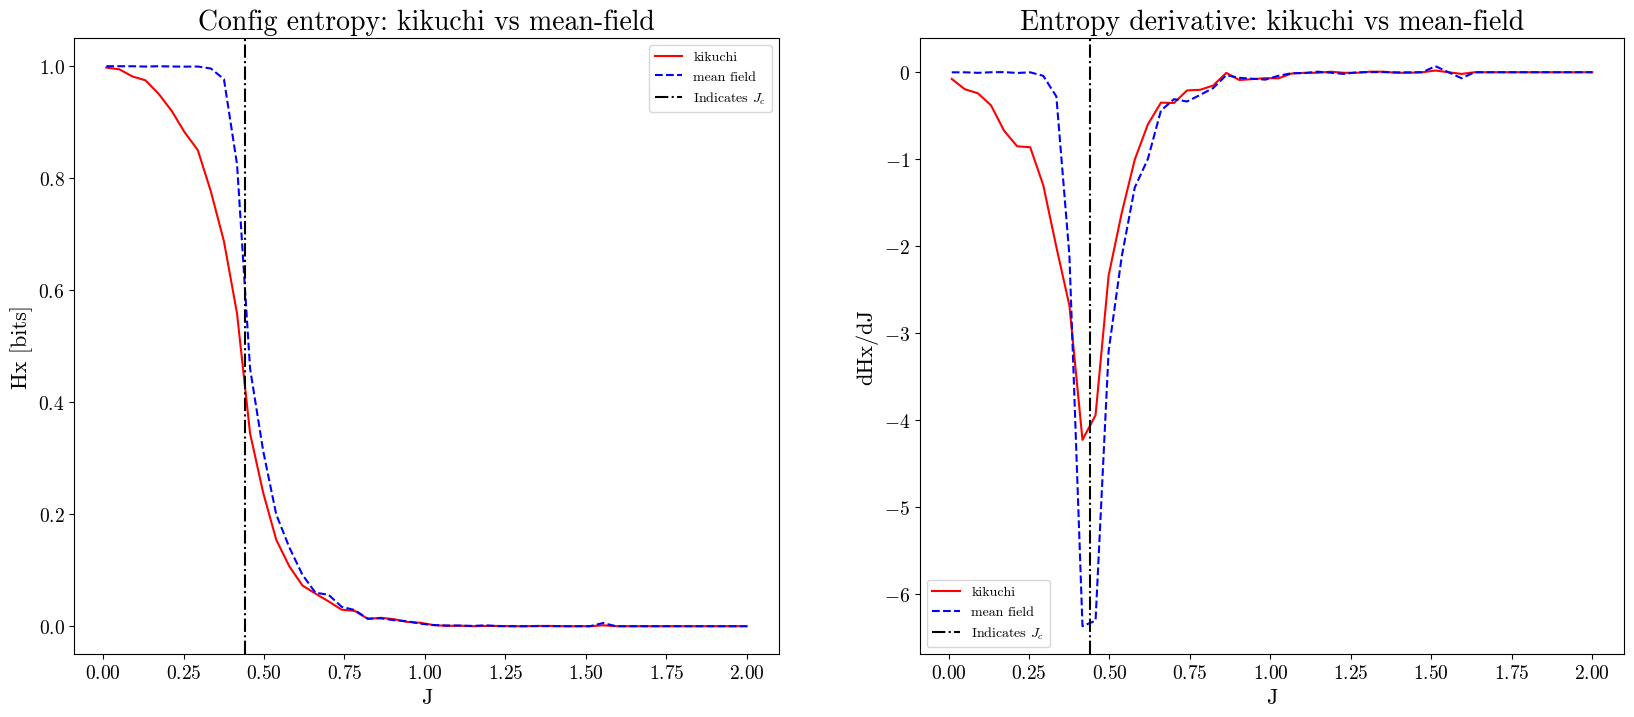

In [8]:
# compare plots
grad_kikuchi = np.gradient(np.array(list(kikuchi.values())),np.array(list(kikuchi.keys())))
grad_meanfield = np.gradient(np.array(list(meanfield.values())),np.array(list(meanfield.keys())))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax = axes[0]
ax.plot(Js, kikuchi.values(), '-', color='r', label='kikuchi');
ax.plot(Js, meanfield.values(), '--', color='b', label='mean field');
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_xlabel('J')
ax.set_ylabel('Hx [bits]')
ax.set_title('Config entropy: kikuchi vs mean-field');
ax.legend();

ax = axes[1]
ax.plot(Js, grad_kikuchi, '-', color='r', label='kikuchi');
ax.plot(Js, grad_meanfield, '--', color='b', label='mean field');
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_xlabel('J')
ax.set_ylabel('dHx/dJ')
ax.set_title('Entropy derivative: kikuchi vs mean-field');
ax.legend();


### Ex2: Compute pdf of given J
What is a better way to get the typical equilibrium distribution of a given J? Is average over time and simulations good enough? Plot to see if the distribution changes smoothly with J. This is important for computing fisher.

In [9]:
def run_experiment2(L, time, j, sampleSize, subsample, numSims):
    M_total = 0
    
    for _ in range(numSims):
        lattice = initialise(L, bias=0.75)  # initialize lattice
        _, _, _, mags, _ = metropolis(lattice, time, j, get_mu(lattice))  # run one simulation
        subsamples = mags[-sampleSize*subsample:][::subsample]  # subsampling to 1/10
        M_total += subsamples.sum()

    return M_total / (numSims * sampleSize)

In [10]:
%%time
# Configuration parameters
numSims = 10
Js = np.linspace(0.01, 2, 50)
L = 50
time = 500000  # perform 500k flips
sampleSize = 200  # take 2k observations to compute average
subsample = 10  # take every 100th sample for subsampling
numSets = 5

# values to keep
result_sets = np.zeros((numSets, len(Js)))

# Use Parallel processing
for i in range(numSets):
    result_sets[i] = Parallel(n_jobs=-1)(delayed(run_experiment2)(L, time, j, sampleSize, subsample, numSims) for j in Js)

CPU times: user 646 ms, sys: 344 ms, total: 990 ms
Wall time: 5min 1s


nmse = 0.03
mae = 0.1746


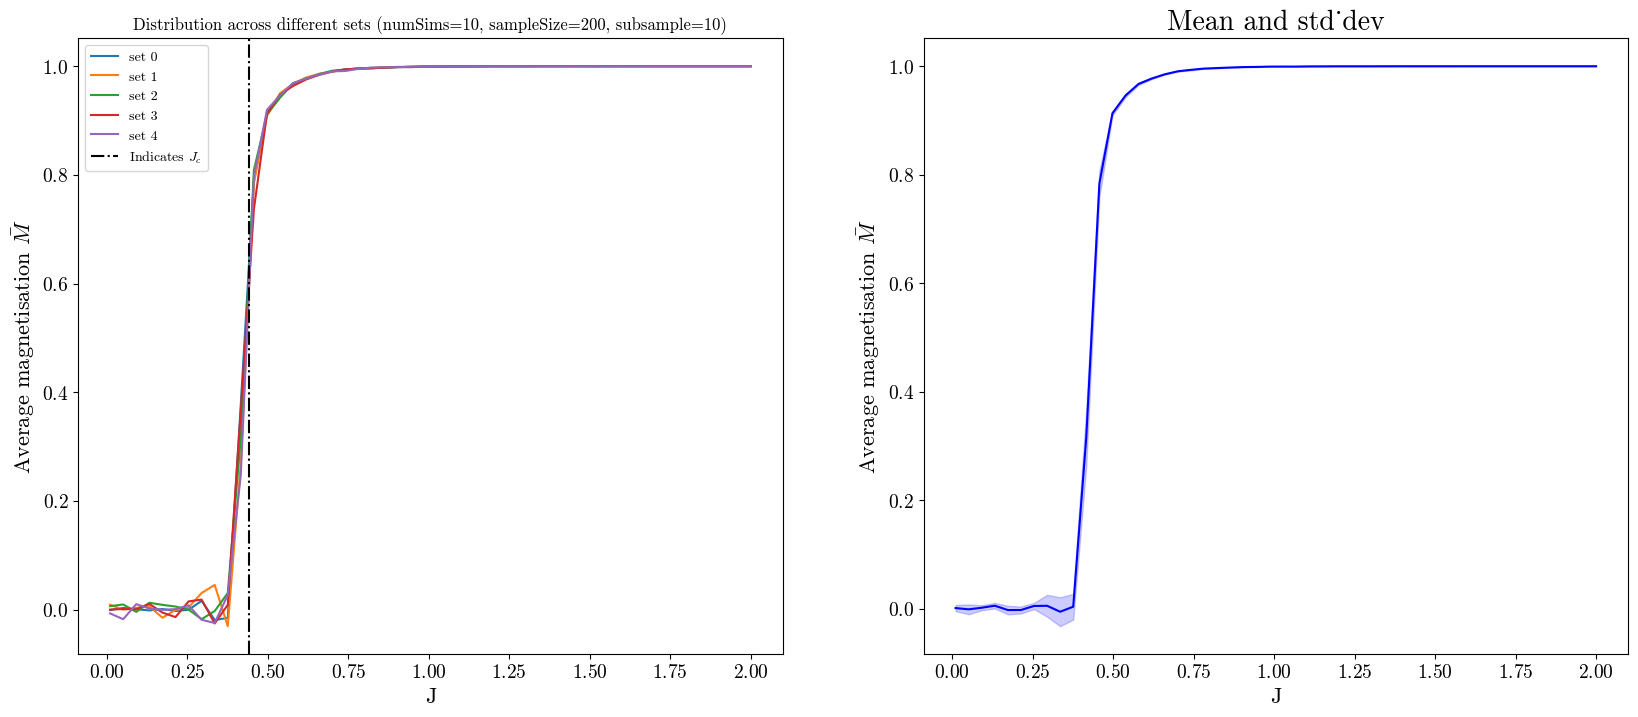

In [11]:
# plot results across sets
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax = axes[0]
for i in range(numSets):
    ax.plot(Js, result_sets[i], label=f'set {i}')
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_xlabel('J');
ax.set_ylabel(r'Average magnetisation $\bar{M}$');
ax.set_title(f'Distribution across different sets (numSims={numSims}, sampleSize={sampleSize}, subsample={subsample})', fontsize=12);
ax.legend();

ax = axes[1]
results_mean, std_dev = quantify_variations(result_sets)
ax.plot(Js, results_mean, label='Mean Curve', color='blue');
ax.fill_between(Js, results_mean - std_dev, results_mean + std_dev, color='blue', alpha=0.2, label='1 Std Dev');
ax.set_title('Mean and std_dev');
ax.set_xlabel('J');
ax.set_ylabel(r'Average magnetisation $\bar{M}$');

**Observations**:

Settings: constant seed=0, Js = np.linspace(0.01,2,50), L = 50, time = 500000 # perform 500k flips

Baseline: numSims = 10, sampleSize = 200, subsample = 10

Results:
- baseline (4mins): nmse = 243.50, mae = 0.1470
- 10x sampleSize (4mins): nmse = 7813.91, mae = 0.1372
- 10x subsampling (4mins): nmse = 99.07, mae = 0.1055
- 3x numSims (14mins): nmse = 779.04, mae = 0.1027

Thoughts:
- 500k flips may not be enough for equilibrium at sub-criticality
- (10x sampleSize): why would mse and mae get bigger when there are more samples to average with?? It could be due to the M for small J gets closer to zero, making the normalising larger. If you look at mae it is actualy down.
- (10x subsampling): nmse and mae increase when samples are less correlated. This means a system which is thought be be at equilibrium is in fact changing a lot with its configuration. Increasing subsampling interval is good because our samples then captures the variation in time, but we also need to increase sample size to get a more reliable number of typical distribution.
- most variation comes from when the systems is evolving "at equilibrium", not from the initial condition. That's why shuffling with more simulations under one set of experiment does not help to bring down nmse and mae. 

### Ex3: Computing fisher information
Compare original definition and square-root approximation. Compare in terms of noise, shape, integral and resulting thermodynamic efficiency.

Also try:

- adding constant
- integrating from the other side

Different approaches:

- From first principle, $I(\theta) = \sum_{x} \frac{1}{p(x|\theta)} (\frac{\partial p(x;\theta)}{\partial \theta})^2$
- With square-root approximation, $I(\theta) = 4*\sum_{x}{(\frac{\sqrt{p(x;\theta+\delta \theta)} - \sqrt{p(x;\theta-\delta \theta)}}{2\delta \theta})^2}$

Ref: 

[1] M. H. DeGroot and M. J. Schervish, Probability and statistics, 4th ed. Boston: Addison-Wesley, 2012.

[2] P. Sánchez-Moreno, R. J. Yanez, and J. S. Dehesa, “Discrete Densities and Fisher Information,” in Proceedings of the 14th International Conference on Difference Equations and Applications, Istanbul, Turkey: Bahçesehir University Press, Oct. 2009, pp. 291–298.

**Conclusion**:


#### 3.0 scrap

In [13]:
def get_fisher_orig(pdf, mode='discrete'):
    """ 
    Compute fisher information using original definition.

    Parameters:
    pdf (dict): A dictionary {theta: f(x)}, where f(x) is also a dictionary ({x:p(x)}). Density function takes the form f(x;theta), 
                and theta is the parameter with respect to which we compute the fisher information. Assume theta is uniformly spaced
    
    Returns:
    dict: Fisher information of different Js.
    """
    thetas = np.array(list(pdf.keys()))
    fisher = {}
    dTheta = thetas[1] - thetas[0] # theta is uniformly spaced

   # Convert pdf dictionaries to arrays
    x_values = np.array(list(pdf[thetas[0]].keys()))
    p_values = np.array([[pdf[theta][x] for x in x_values] for theta in thetas])
    # log_p_values = np.log(p_values) # using log(p) makes it very unstable as p->0 log(p)-> -inf
    # print('log_p_values:')
    # print(log_p_values)
    
    # Compute the gradient of p_values with respect to theta
    dp_dtheta = np.gradient(p_values, thetas, axis=0)
    # dlogp_dtheta = np.gradient(log_p_values, thetas, axis=0)
    # print(dlogp_dtheta)
    
    # Compute Fisher Information for each theta
    # for i, theta in enumerate(thetas):
    #     fisher[theta] = np.sum((dp_dtheta[i]**2) / p_values[i])
    if mode == 'discrete':
        for i, theta in enumerate(thetas):
            # Avoid division by zero, sum over x
            valid_mask = p_values[i] > 0
            fisher[theta] = np.sum((dp_dtheta[i][valid_mask]**2) / p_values[i][valid_mask])
            # fisher[theta] = np.sum((dlogp_dtheta[i]**2) * p_values[i])
    else:
        for i, theta in enumerate(thetas):
            valid_mask = p_values[i] > 0
            # fisher[theta] = np.trapz((dlogp_dtheta[i][valid_mask]**2) * p_values[i][valid_mask], x_values[valid_mask])
            fisher[theta] = np.trapz((dp_dtheta[i][valid_mask]**2) / p_values[i][valid_mask], x_values[valid_mask])
        
    return fisher
    
# OBSELETE - UPDATED WITH NP.GRADIENT(), RESULT HAS NOT CHANGED    
def get_fisher_sqrt2(pdf):
    """ 
    Compute fisher information using squareroot approximation.

    Parameters:
    pdf (dict): A dictionary {theta: f(x)}, where f(x) is also a dictionary ({x:p(x)}). Density function takes the form f(x;theta), 
                and theta is the parameter with respect to which we compute the fisher information. Assume theta is uniformly spaced
    
    Returns:
    dict: Fisher information of different Js.
    """
    thetas = np.array(list(pdf.keys()))
    fisher = {}

    for i, theta in enumerate(pdf.keys()):
        if i == 0:
            # forward difference for the first theta
            thetaPlus = thetas[i+1]
            dTheta = thetaPlus - theta
            p = pdf[theta] #f(x;J)
            pPlus = pdf[thetaPlus] #f(x;J+dJ)
            allX = set(p.keys()).union(set(pPlus.keys())) # set of all possible sigmas ({-1, 1})
            fi = 0
            for x in allX:
                fi = fi + 4* ((pPlus.get(x,0)**0.5 - p.get(x,0)**0.5)/dTheta)**2 # fi = 4 * sum_x{(d_sqrt(p)/d_theta)^2}
        elif i == len(thetas) - 1:
            # backward difference for the last theta
            thetaMinus = thetas[i-1]
            dTheta = theta - thetaMinus
            p = pdf[theta]
            pMinus = pdf[thetaMinus] #f(x;J-dJ)
            allX = set(p.keys()).union(set(pMinus.keys())) 
            fi = 0
            for x in allX:
                fi = fi + 4* ((p.get(x,0)**0.5 - pMinus.get(x,0)**0.5)/dTheta)**2
        else:
            # central difference for other thetas
            thetaMinus = thetas[i-1]
            thetaPlus = thetas[i+1]
            dTheta = thetaPlus - thetaMinus
            pMinus = pdf[thetaMinus]
            pPlus = pdf[thetaPlus] 
            allX = set(pPlus.keys()).union(set(pMinus.keys())) 
            fi = 0
            for x in allX:
                fi = fi + 4* ((pPlus.get(x,0)**0.5 - pMinus.get(x,0)**0.5)/dTheta)**2 
        fisher[theta] = fi    
    return fisher

def get_fisher_sqrt(pdf, mode='discrete'):
    """
    Compute fisher information using squareroot approximation.

    Parameters:
    pdf (dict): A dictionary {theta: f(x)}, where f(x) is also a dictionary ({x:p(x)}). Density function takes the form f(x;theta), 
                and theta is the parameter with respect to which we compute the fisher information. Assume theta is uniformly spaced
    
    Returns:
    dict: Fisher information of different Js.
    """
    thetas = np.array(list(pdf.keys()))
    fisher = {}
    dTheta = thetas[1] - thetas[0] # theta is uniformly spaced

    # Convert pdf dictionaries to arrays
    x_values = list(pdf[thetas[0]].keys())
    p_values = np.array([[pdf[theta].get(x, 0) for x in x_values] for theta in thetas])

    # Compute the square root of p_values
    sqrt_p_values = np.sqrt(p_values)

    # Compute the gradient of sqrt_p_values with respect to theta
    dsqrtp_dtheta = np.gradient(sqrt_p_values, thetas, axis=0)

    # Compute Fisher Information for each theta
    if mode == 'discrete':
        for i, theta in enumerate(thetas):
            fisher[theta] = 4* np.sum(dsqrtp_dtheta[i]**2) # this is good for discrete distribution pmf(x)
    else:
        for i, theta in enumerate(thetas):
            fisher[theta] = 4 * np.trapz(dsqrtp_dtheta[i]**2, x_values) # this is good for continuous distribution pdf(x)

    return fisher

In [ ]:
# check np.gradient() on a known function

def fx(x):
    return x**3 + 4 * x + np.sin(x)

def dfdx(x):
    return 3*(x**2) + 4 + np.cos(x)

x = np.linspace(-1, 1, 100)
y = fx(x)
dydx_analytical = dfdx(x)
dydx_numerical = np.gradient(y,x)
plt.plot(x, dydx_analytical, '-', color='r', label='analytical');
plt.plot(x, dydx_numerical, '--', color='b', label='numerical');

#### 3.0 Define functions

In [12]:
def get_fisher(pdf, method = 'sqrt', mode='discrete'):
    """
    Compute fisher information using two different methods. Default is square-root approximation because it is more stable when p is small.

    Parameters:
    pdf (dict): A dictionary {theta: f(x)}, where f(x) is also a dictionary ({x:p(x)}). Density function takes the form f(x;theta), 
                and theta is the parameter with respect to which we compute the fisher information. Assume theta is uniformly spaced
    
    Returns:
    dict: Fisher information of different Js.
    """
    thetas = np.array(list(pdf.keys()))
    fisher = {}
    dTheta = thetas[1] - thetas[0] # theta is uniformly spaced

    # Convert pdf dictionaries to arrays
    x_values = np.array(list(pdf[thetas[0]].keys()))
    p_values = np.array([[pdf[theta].get(x, 0) for x in x_values] for theta in thetas])

    if method == 'sqrt':
        # Compute the square root of p_values
        sqrt_p_values = np.sqrt(p_values)
    
        # Compute the gradient of sqrt_p_values with respect to theta
        dsqrtp_dtheta = np.gradient(sqrt_p_values, thetas, axis=0)
    
        # Compute Fisher Information for each theta
        if mode == 'discrete':
            for i, theta in enumerate(thetas):
                fisher[theta] = 4* np.sum(dsqrtp_dtheta[i]**2) # this is good for discrete distribution pmf(x)
        else:
            for i, theta in enumerate(thetas):
                fisher[theta] = 4 * np.trapz(dsqrtp_dtheta[i]**2, x_values) # this is good for continuous distribution pdf(x)
    else: 
        # using original sum_x {(dp_dtheta)^2 / p}
        # Compute the gradient of p_values with respect to theta. Use dp_dtheta is more stable than dlogp_dtheta when p is small
        dp_dtheta = np.gradient(p_values, thetas, axis=0)
        
        # Compute Fisher Information for each theta
        if mode == 'discrete':
            for i, theta in enumerate(thetas):
                # Avoid division by zero, sum over x
                valid_mask = p_values[i] > 0
                fisher[theta] = np.sum((dp_dtheta[i][valid_mask]**2) / p_values[i][valid_mask])
        else:
            for i, theta in enumerate(thetas):
                valid_mask = p_values[i] > 0
                fisher[theta] = np.trapz((dp_dtheta[i][valid_mask]**2) / p_values[i][valid_mask], x_values[valid_mask])

    return fisher

In [14]:
def run_experiment3(L, time, j, sampleSize, subsample, numSims):
    entp_total = 0
    M_total = 0
    
    for _ in range(numSims):
        lattice = initialise(L, bias=0.75)  # initialize lattice
        _, _, _, mags, _ = metropolis(lattice, time, j, get_mu(lattice))  # run one simulation
        subsamples = mags[-sampleSize*subsample:][::subsample]  # subsampling to 1/10
        M_total += subsamples.sum()
        entp_total += get_entropy_kikuchi(lattice)
    Mbar = M_total / (numSims * sampleSize) 

    return {1:(1 + Mbar) / 2, -1:(1 - Mbar) / 2}, entp_total / numSims

In [15]:
# compare two ways to compute fisher: original vs sqrt
def compare_plot_ex3(ave_pdf, ave_entp, get_eta):
    """
    Compare different get_eta functions. No filters applied to fisher information yet (filters tested in the next exercise).
    
    Parameters:
    ave_pdf (dict): The average probability density function.
    ave_entp (dict): The average entropy.
    get_eta_func (function): Function to compute eta. Should match the signature of the original get_eta function.
    
    """

    # compute fisher and eta
    fisher_sqrt = get_fisher(ave_pdf, method='sqrt', mode='discrete')
    fisher_orig = get_fisher(ave_pdf, method='orig', mode='discrete')
    eta_sqrt, hx, numerator, _, fisher_sqrt_intg = get_eta(ave_entp, fisher_sqrt, entropyFilt=True, derivativeFilt=True)
    eta_orig, hx, numerator, _, fisher_orig_intg = get_eta(ave_entp, fisher_orig, entropyFilt=True, derivativeFilt=True)
    
    # compare plots
    Js = np.array(list(ave_entp.keys()))
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
    
    ax = axes[0][0]
    ax.plot(fisher_sqrt.keys(), fisher_sqrt.values(), '-', color='r', label='sqrt');
    ax.plot(fisher_orig.keys(), fisher_orig.values(), '--', color='b', label='original');
    ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
    ax.set_xlabel('J')
    ax.set_ylabel(r'$I(\theta)$')
    ax.set_title('Fisher information: sqrt or original');
    ax.legend();
    
    ax = axes[0][1]
    ax.plot(Js, fisher_sqrt_intg, '-', color='r', label='sqrt');
    ax.plot(Js, fisher_orig_intg, '--', color='b', label='original');
    ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
    ax.set_xlabel('J')
    ax.set_ylabel(r'$I(\theta)$')
    ax.set_title('Fisher information integral: sqrt or original');
    ax.legend();
    
    ax = axes[1][0]
    ax.plot(ave_entp.keys(), ave_entp.values(), '-', color='c', label='raw');
    ax.plot(ave_entp.keys(), hx, '--', color='g', label='filtered');
    ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
    ax.set_xlabel('J')
    ax.set_ylabel('Hx [bit]')
    ax.set_title('Entropy');
    ax.legend();
    
    ax = axes[1][1]
    ax.plot(Js, eta_sqrt.values(), '-', color='r', label='sqrt');
    ax.plot(Js, eta_orig.values(), '--', color='b', label='original');
    ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
    ax.set_xlabel('J')
    ax.set_ylabel(r'$\eta(\theta)$')
    ax.set_title('Thermodynamic efficiency: sqrt or original');
    ax.legend();
    return eta_sqrt, eta_orig, hx, numerator, fisher_sqrt, fisher_orig, fisher_sqrt_intg, fisher_orig_intg

#### 3.1 Check fisher calculation with known distributions

np.gradient, manual derivative and original definition produce the same result for Gaussian. But they are all off by a factor. Need to investigate if this factor changes with $\sigma$ and sample size n.

Updates:

- replace manual derivative by np.gradient() -> doesn't change result
- adding mask to avoid division by zero -> resolved error
- use np.gradient(f, theta) instead of np.gradient(f) -> resolved discrepancy in Bernoulli & Gaussian
- use np.sum() for discrete x and np.trapez() for continuous x -> resolved discrepancy in Gaussian

Notes:

- there is still discrepancy especially at the boundary of theta, due to the way gradient is computed. But it is only for the two end points hence ignore them;
- the original method generally have results closer to analytical, but it is more sensitive to choice of dTheta. I kept both methods, just to see which one works better in Ising model.

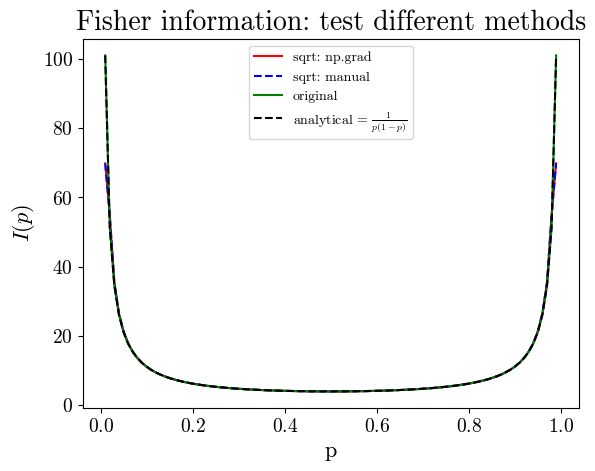

In [16]:
# test fisher computation on Bernoulli distribution
from scipy.stats import bernoulli
def generate_bernoulli_pdf(p_values):
    pmf = {}
    x_values = [0,1]  # Define a range for x values
    for p in p_values:
        pmf[p] = {x: bernoulli.pmf(x, p) for x in x_values}
    return pmf

# Generate a PDF dictionary for the normal distribution
p_values = np.linspace(0.01, 0.99, 100)
pdf = generate_bernoulli_pdf(p_values)

# Calculate Fisher Information using both functions
fisher_info1 = get_fisher(pdf, method='sqrt')
fisher_info2 = get_fisher_sqrt2(pdf)
fisher_info3 = get_fisher(pdf, method='orig')

# Analytical Fisher Information for Normal Distribution
fisher_analytical = 1 / (p_values * (1 - p_values))

plt.plot(p_values, fisher_info1.values(), color='r', label='sqrt: np.grad');
plt.plot(p_values, fisher_info2.values(), '--',color='b', label='sqrt: manual');
plt.plot(p_values, fisher_info3.values(), '-', color='g', label='original');
plt.plot(p_values, fisher_analytical, '--',color='k', label=r'analytical = $\frac{1}{p(1-p)}$')
plt.xlabel('p')
plt.ylabel(r'$I(p)$')
# plt.ylim((0,40))
plt.title('Fisher information: test different methods');
plt.legend();

Observations:

- Both original and square-root method aligns well with analytical results. When it comes to boundaries, original method is closer to analytical. Original is also closer when dp becomes larger.
- Using trapezoidal rule in $\sum_x$ underestimates $I(\theta)$ for discrete distributions (as it should be sum of rectangles not trapezoi), but will be a better approximation for continuous distribution like Gaussian (see later exercise). For purpose of Ising model, distribution is discrete, hence I need to use sum rectangles, not np.trapez().

In [17]:
# test fisher computation on Gaussian distribution
from scipy.stats import norm
def generate_normal_pdf(mu_values, sigma):
    pdf = {}
    x_values = np.linspace(-10, 10, 1000)  # Define a range for x values
    for mu in mu_values:
        pdf[mu] = {x: norm.pdf(x, mu, sigma) for x in x_values}
    return pdf

# Generate a PDF dictionary for the normal distribution
mu_values = np.linspace(-3, 3, 100)
sigma = 0.1
pdf = generate_normal_pdf(mu_values, sigma)

# Calculate Fisher Information using both functions
fisher_info1 = get_fisher(pdf, method='sqrt', mode='continuous')
fisher_info2 = get_fisher_sqrt2(pdf)
fisher_info3 = get_fisher(pdf, method='orig', mode='continuous')

# Analytical Fisher Information for Normal Distribution
analytical_fisher_info = 1 / sigma**2
fisher_analytical = [analytical_fisher_info] * len(mu_values)

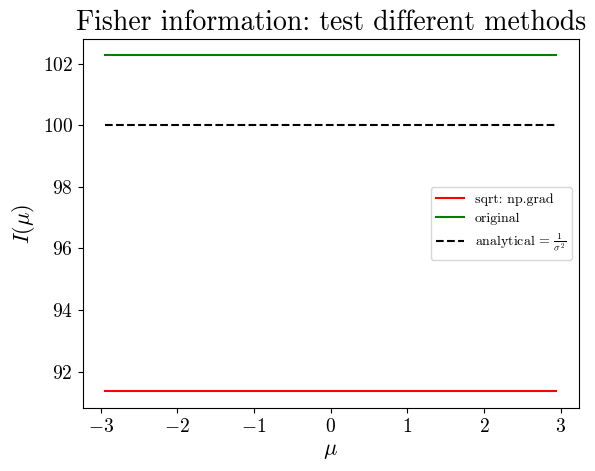

In [18]:
plt.plot(mu_values[1:-1], list(fisher_info1.values())[1:-1], color='r', label='sqrt: np.grad');
# plt.plot(mu_values[1:-1], list(fisher_info2.values())[1:-1], '--',color='b', label='sqrt: manual');
plt.plot(mu_values[1:-1], list(fisher_info3.values())[1:-1], '-', color='g', label='original');
plt.plot(mu_values[1:-1], fisher_analytical[1:-1], '--', color='k', label=r'analytical = $\frac{1}{\sigma^2}$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$I(\mu)$')
plt.title('Fisher information: test different methods');
plt.legend();

Observations:

- Original method is more sensitive to change in dTheta.
- When $\sigma$ is small (i.e. very sharp pdf), both numerical methods have big discrepancies. Sqrt is more stable, but much smaller than analytical; original is radical, and much larger than theoretical. This gets worse then dx is small.

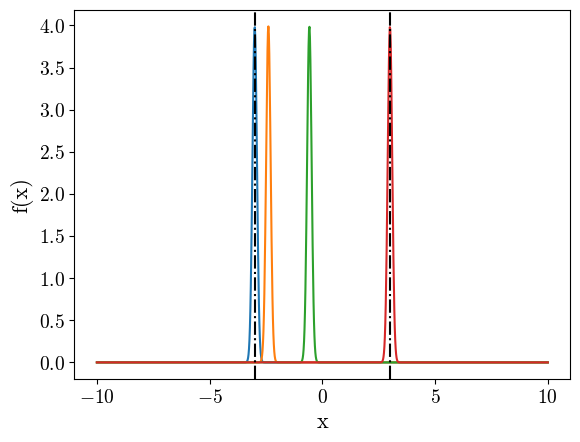

In [19]:
plt.plot(pdf[mu_values[0]].keys(), pdf[mu_values[0]].values());
plt.plot(pdf[mu_values[10]].keys(), pdf[mu_values[10]].values());
plt.plot(pdf[mu_values[40]].keys(), pdf[mu_values[40]].values());
plt.plot(pdf[mu_values[99]].keys(), pdf[mu_values[99]].values());
plt.axvline(x=mu_values[0], color='k', linestyle='-.');
plt.axvline(x=mu_values[99], color='k', linestyle='-.');
plt.xlabel('x');
plt.ylabel('f(x)');

In [ ]:
# compare the ratio of estimated fisher and actual fisher
plt.plot(mu_values, np.array(list(fisher_info1.values()))/np.array(fisher_analytical));
plt.xlabel(r'$\mu$');
plt.ylabel(r'$\hat{I}(\mu)/I(\mu)$');
plt.title(f'$\sigma = {sigma:.4f}$');

#### 3.2 Simulate Ising model

In [20]:
%%time
numSims = 10
Js = np.linspace(0.01,2,200)
L = 50
time = 1200000 # perform 1.2mil flips
sampleSize = 2000 # take 2k observations to compute average
subsample = 100 # take every 100th sample for subsampling

# values to keep
ave_pdf = {}
ave_entp = {}

for j in Js:
    ave_pdf[j], ave_entp[j] = run_experiment3(L, time, j, sampleSize, subsample, numSims)

CPU times: user 48min 36s, sys: 14.4 s, total: 48min 50s
Wall time: 48min 54s


In [ ]:
# combine and export
combined_data = {
    'ave_pdf': ave_pdf,
    'ave_entp': ave_entp
}

# Save combined data to a JSON file
with open('data_ex3_20240807.json', 'w') as json_file:
    json.dump(combined_data, json_file)

# Load combined data from a JSON file
with open('data_ex3_20240807.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Access individual dictionaries
ave_pdf = loaded_data['ave_pdf']
ave_entp = loaded_data['ave_entp']

#### 3.3 Check np.gradient() on Ising model
Updates:

- np.gradient code returns same result as manual derivative. Manual derivative code obselete from now.
- get_eta replaces mask with np.where when calculating eta. This is because np.where evaluates all its arguments before applying condition so I will still get the divide by zero error message. -> resolved divide by zero error message.

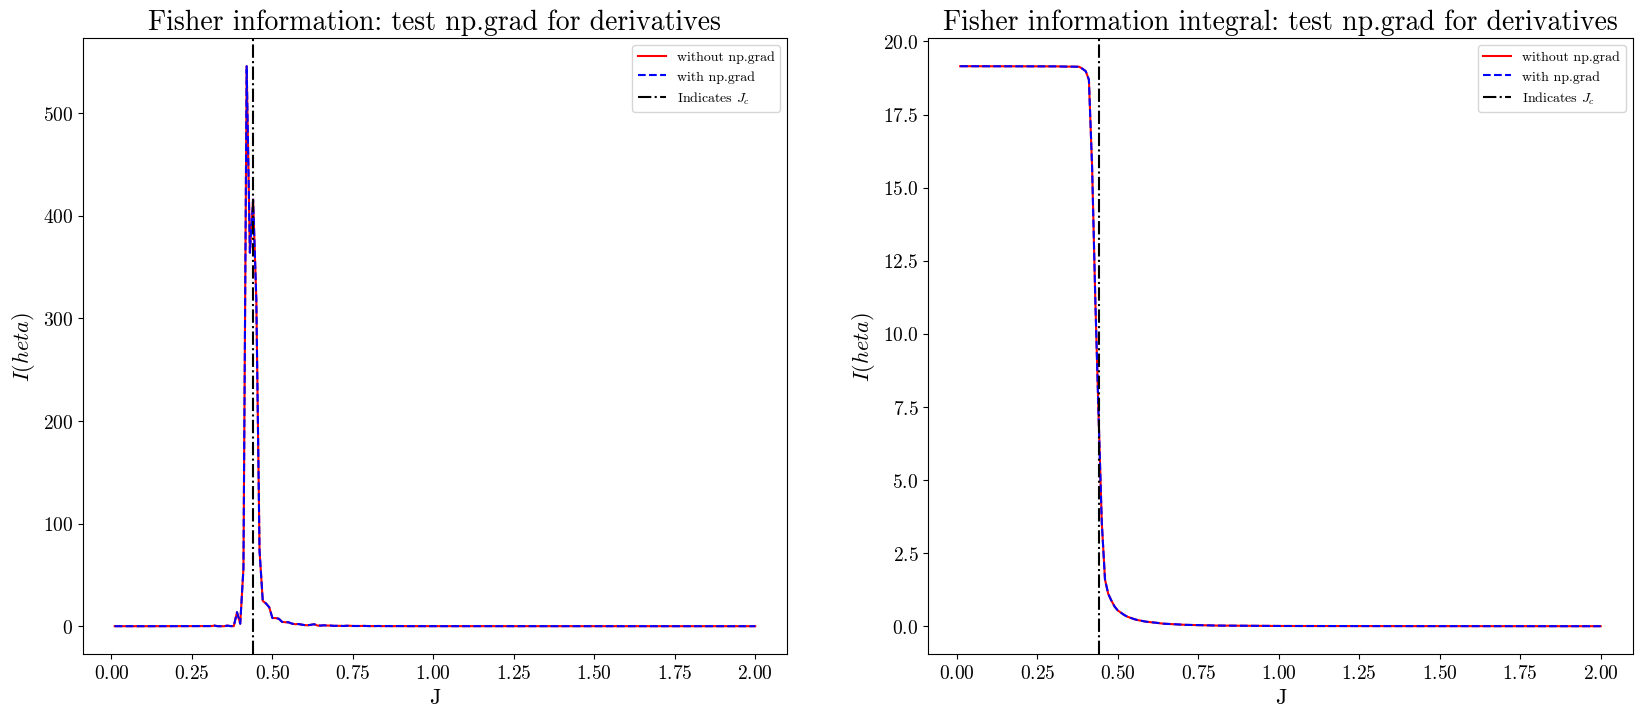

In [24]:
# compare two ways to compute fisher with square root (with/out np.gradient())
# compute fisher
fisher_sqrt = get_fisher_sqrt(ave_pdf)
fisher_sqrt2 = get_fisher_sqrt2(ave_pdf)
eta_sqrt, _, numerator, _, fisher_sqrt_intg = get_eta0(ave_entp, fisher_sqrt, window=8)
eta_sqrt2,  _, numerator, _, fisher_sqrt2_intg = get_eta0(ave_entp, fisher_sqrt2, window=8)

# compare plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax = axes[0]
ax.plot(fisher_sqrt.keys(), fisher_sqrt.values(), '-', color='r', label='without np.grad');
ax.plot(fisher_sqrt2.keys(), fisher_sqrt2.values(), '--', color='b', label='with np.grad');
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_xlabel('J')
ax.set_ylabel('$I(\theta)$')
ax.set_title('Fisher information: test np.grad for derivatives');
ax.legend();

ax = axes[1]
ax.plot(Js, fisher_sqrt_intg, '-', color='r', label='without np.grad');
ax.plot(Js, fisher_sqrt2_intg, '--', color='b', label='with np.grad');
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_xlabel('J')
ax.set_ylabel('$I(\theta)$')
ax.set_title('Fisher information integral: test np.grad for derivatives');
ax.legend();

#### 3.4 Compare square-root and original fisher

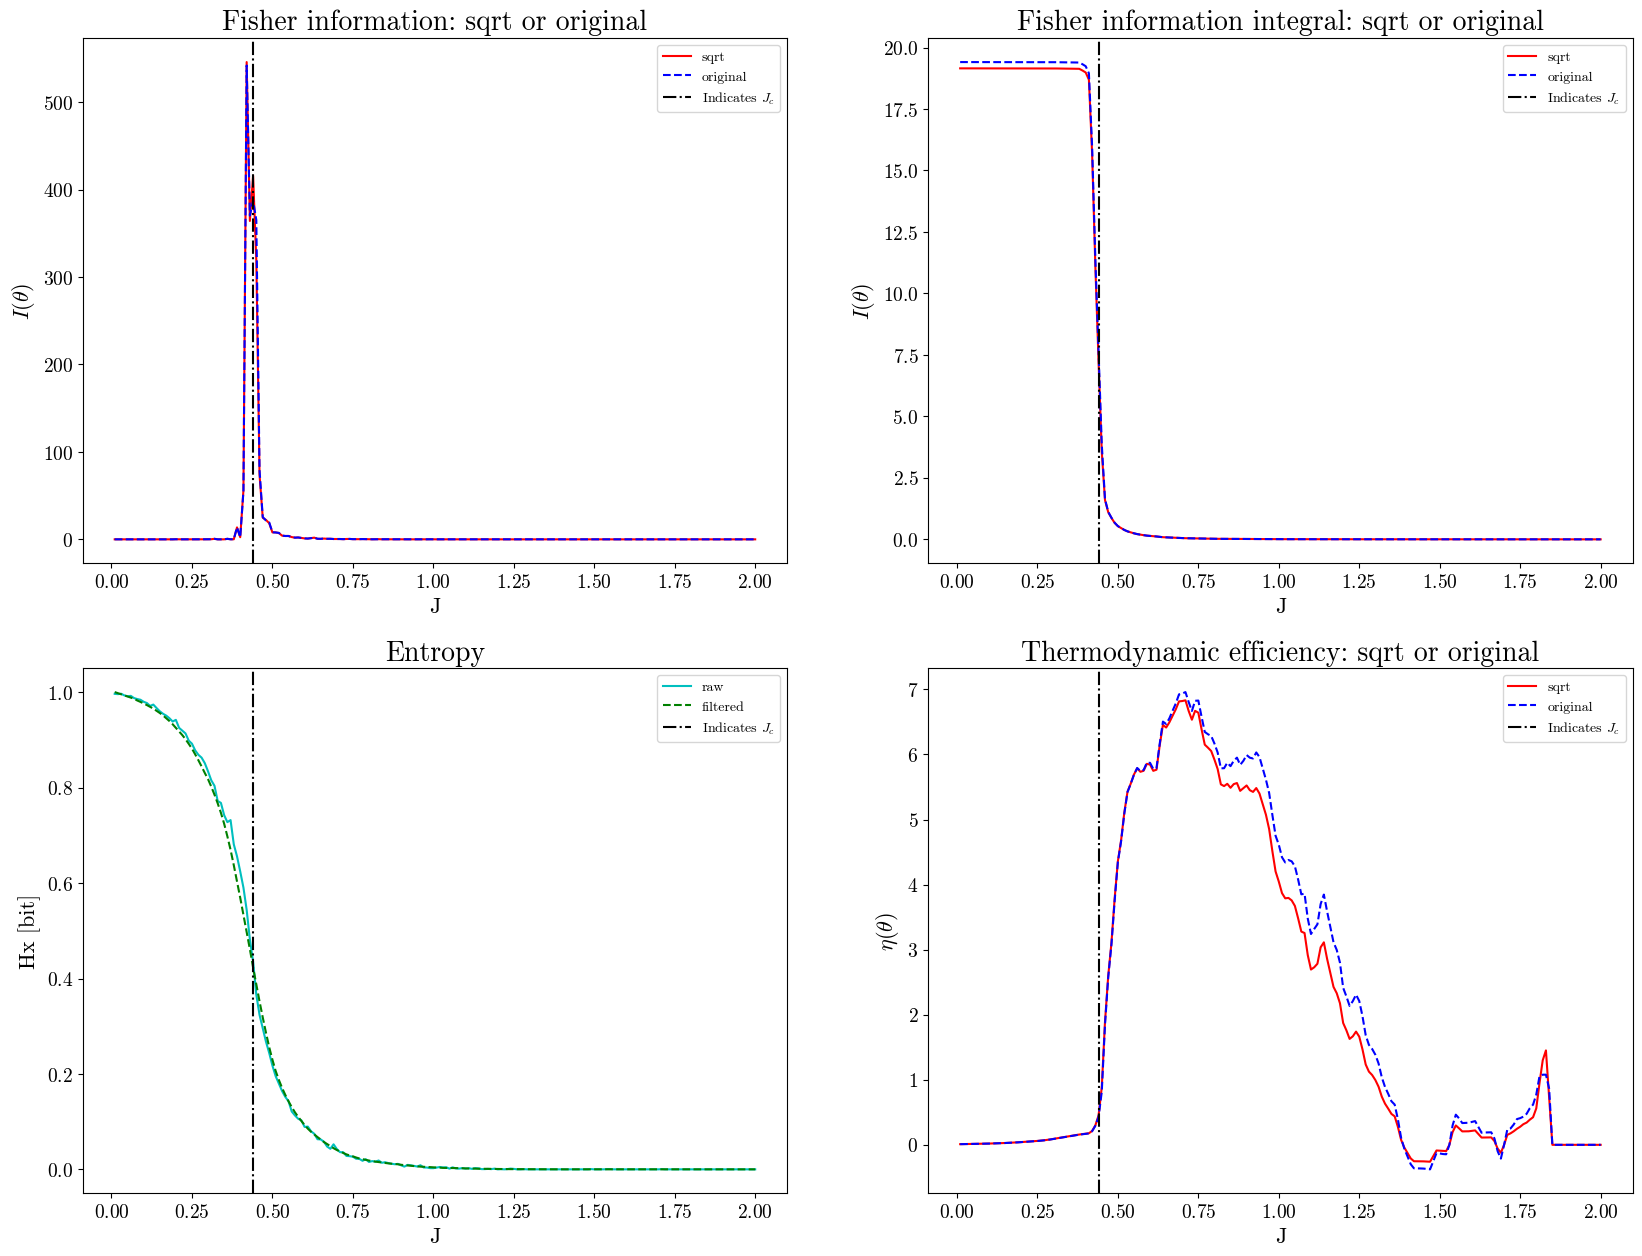

In [25]:
_ = compare_plot_ex3(ave_pdf, ave_entp, get_eta0)

#### 3.5 Integrate from the left

Why integration from the left would be so different? Shouldn't it be symmetrical?

- Due to denominator being too small (10^-3 scale), when divided, the noise in denominator is massively amplified. Note that noise in the numerator is larger at subcritical region as we can see in Ex2. Therefore integrating from the left makes $\eta$ more susceptible to noises in numerator.
- Next want to check if it will be better to turn on filter for fisher integral.

In [26]:
# integrating from left
def get_eta1(configEntropy, fisherInfo, entropyFilt=False, derivativeFilt=False, fisherFilt=False, integralFilt=False, window=14):
    """
    Compute thermodynamic efficiency.
    
    Parameters:
    configEntropy (dict): A dictionary with parameter and configuration entropy.
    fisherInfo (dict): A dictionary with parameter and Fisher information.
    entropyFilt, derivativeFilt, fisherFilt, integralFilt (bool): switches for filters (Savitzky-Golay filter).
    window (int): window size for the filter.
    
    Returns:
    dict: thermodynamic efficiency eta;
    np.array: configuration entropy values extracted from configEntropy, for checking;
    np.array: numerators for each eta, for checking;
    np.array: fisher information values extracted from fisherInfo, for checking;
    np.array: denominators for each eta, for checking.
    """
    theta = np.array(list(configEntropy.keys()))
    hx = np.array(list(configEntropy.values()))
    fisher = np.array(list(fisherInfo.values()))
    denominator = {}

    # apply filters: entropy, fisher
    if entropyFilt:
        hx = savgol_filter(hx, window_length=window, polyorder=1)
    if fisherFilt:
        fisher = savgol_filter(fisher, window_length=window, polyorder=1)
    
    # compute numerator, denominator
    numerator = np.gradient(hx,theta)
    for i,j in enumerate(theta):
        denominator[j] = np.trapz(fisher[:i], theta[:i]) # integrate from theta0 to point to zero-response
    denominator = np.array(list(denominator.values()))
    
    # apply filters: derivative, integral
    if derivativeFilt:
        numerator = savgol_filter(numerator, window_length=window, polyorder=1)
    if integralFilt:
        denominator = savgol_filter(denominator, window_length=window, polyorder=1)
    # compute eta
    mask = (abs(denominator) < EPSILON) | (abs(numerator) < EPSILON)
    eta = np.zeros_like(numerator)
    eta[~mask] = -numerator[~mask] / denominator[~mask]
    etaDict = dict(zip(theta, eta))
    return etaDict, hx, numerator, fisher, denominator

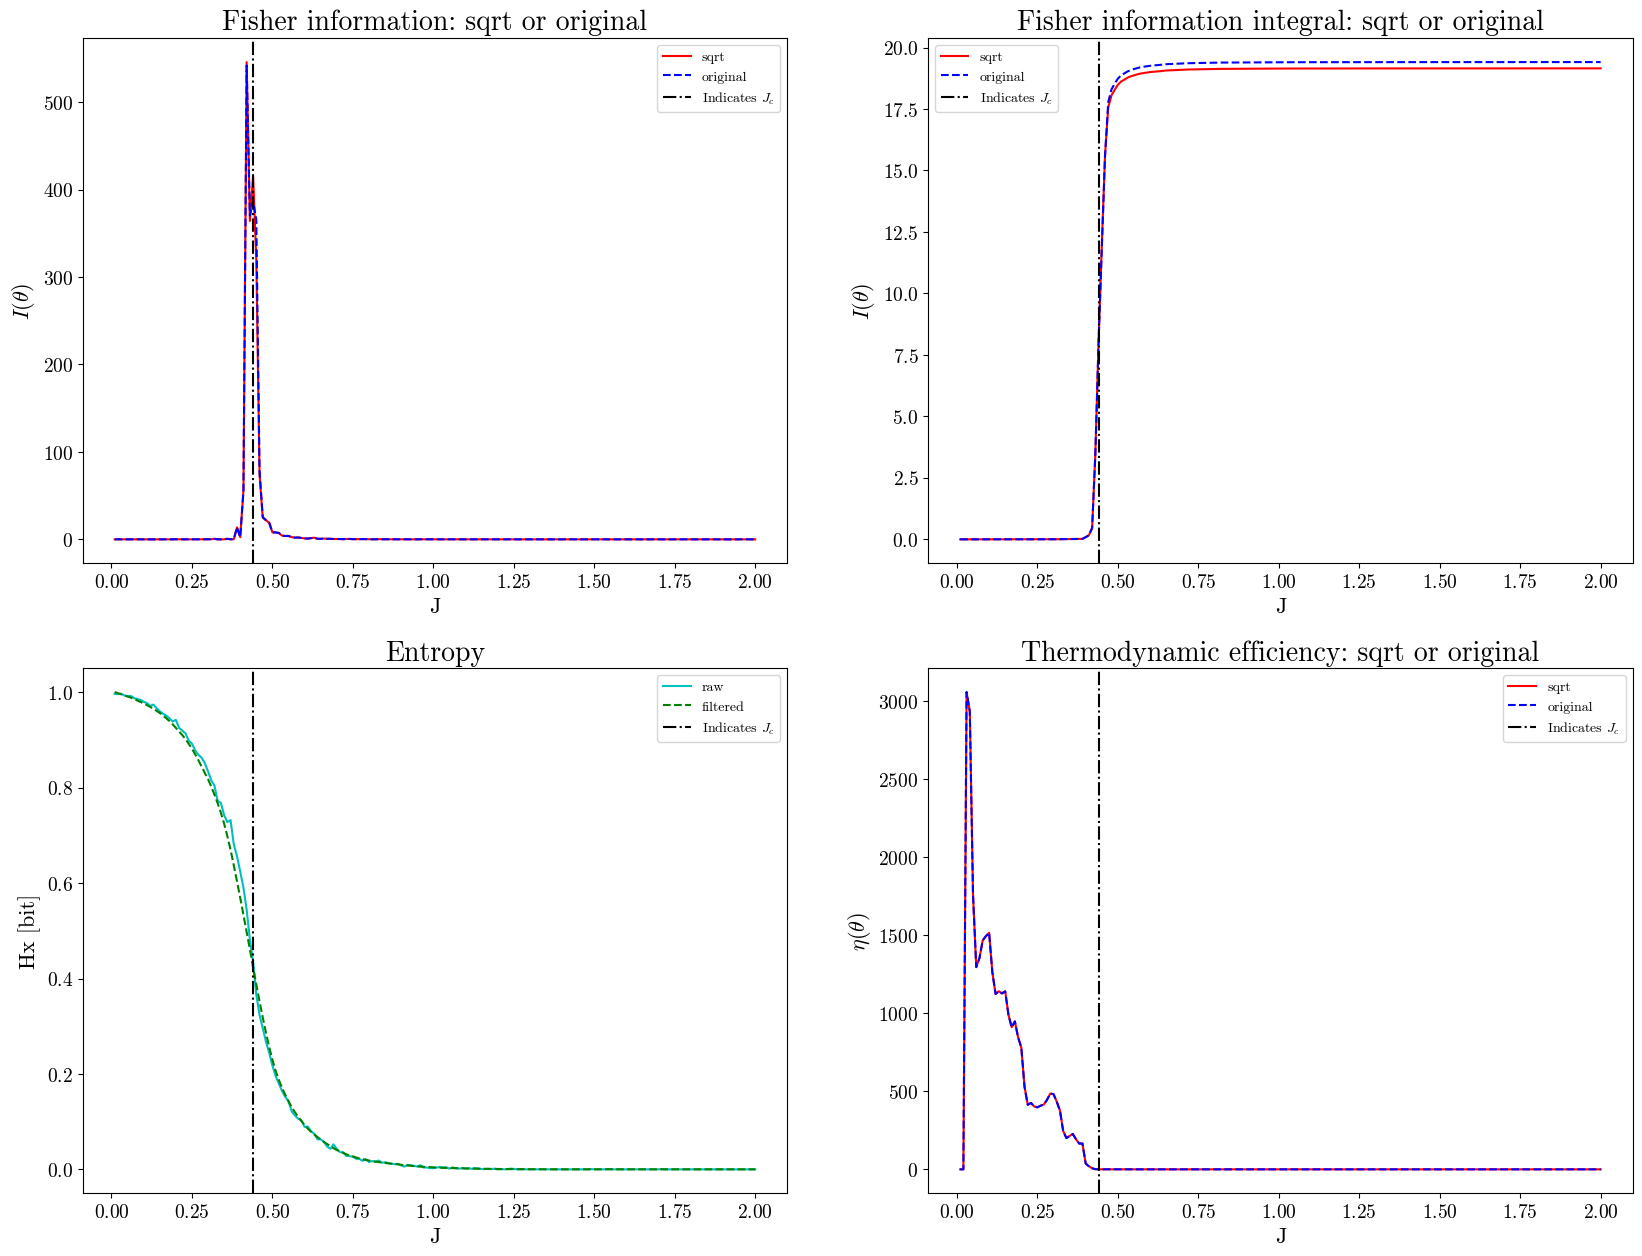

In [27]:
eta_sqrt, eta_orig, hx, numer, fi_sqrt, fi_orig, denom_sqrt, denom_orig = compare_plot_ex3(ave_pdf, ave_entp, get_eta1)

In [ ]:
# interactive plot
# name = 'fisher information'
x = list(ave_entp.keys())
# y1 = list(fi_sqrt.values())
# y2 = list(fi_orig.values())
# y1_label = 'sqrt'
# y2_label = 'orig'

name = '1/ (fisher integral)'
y1 = list(1/denom_sqrt)
y2 = list(1/denom_orig)
y1_label = 'sqrt'
y2_label = 'orig'

# name = 'thermodynamic efficiency'
# y1 = list(eta_sqrt.values())
# y2 = list(eta_orig.values())
# y1_label = 'sqrt'
# y2_label = 'orig'

# name = 'thermodynamic efficiency'
# y1 = list(ave_entp.values())
# y2 = list(hx)
# y1_label = 'pre-filter'
# y2_label = 'post-filter'

# name = 'entropy derivative'
# y1 = list(numer)
# y2 = list(numer)
# y1_label = 'entropy derivative'
# y2_label = ''
interactive_plot(name, x, y1, y2, y1_label, y2_label, filename='tmp')

In [ ]:
# check actual numbers
id = 12
print(f'J={x[id]}, eta = {-numer[id]:.4f}/{denom_orig[id]:.4f} = {-numer[id]/denom_orig[id]}, result = {eta_orig[x[id]]:.4f}')

#### 3.6 Adding constant

**Observations**:

- Adding constant to individual fisher value (cumulative shift) or the final integral (constant shift) have almost the same effect on where $\eta$ peaks and the smoothness of the curve -> meaning that the peak and noise in $\eta$ may purely due to noise and dividing by small number, otherwise cumulative shift will be much more effective than constant shift.
- Adding constant shifted the peak towards critical point: increase constant makes peak of $\eta$ shift to the left, and eventually end up at criticality. -> implies peak of $\eta$ to the right of criticality may be due to simulation noise. Main problem is in fisher integration.
- Adding constant makes the tail much smoother: at the tail, where the integral of fisher is close to zero, 1/denominator gets really large, that's why the tail is so noisy. Adding a constant outweights the noise.


**Conclusion**:
- Need to improve denominator: (1)try to avoid dividing by very small number (improve absolute terms); (2)try smooth it (improve noise).
- Three solutions: (1) run more simulations, make fisher more robust; (2) apply filter to fisher and fisher integral; (3) use a larger upperbound of $\theta$ to compute the integral, such that you don't reach the boundary (this has a similar effect of adding constant)
- but these still don't solve the problem of dividing by small number, hence $\eta$ may still peak at the right.

**Thoughts**:
- to use solution (3), I need to work out a way to compute I($\theta^*$) without having to run everything between the cut-off and $\theta^*$. For example, I plot $\theta \in (0,2)$, but I want to integral to go from $\int_{\theta}^{10} I(t)dt$. Then I need $I(10)$. To compute $I(10)$ I'd need $\frac{dp(x|10)}{dx}$ -> I only need to run $\theta=10$ once?
- About the area: np.trapz() can do the tail bit properly if I give it $I(10)$, but if I use the sum I need to manually add that area.

In [28]:
# adding constant to fisher
def get_eta2(configEntropy, fisherInfo, entropyFilt=False, derivativeFilt=False, fisherFilt=False, integralFilt=False, window=14):
    """
    Compute thermodynamic efficiency.
    
    Parameters:
    configEntropy (dict): A dictionary with parameter and configuration entropy.
    fisherInfo (dict): A dictionary with parameter and Fisher information.
    entropyFilt, derivativeFilt, fisherFilt, integralFilt (bool): switches for filters (Savitzky-Golay filter).
    window (int): window size for the filter.
    
    Returns:
    dict: thermodynamic efficiency eta;
    np.array: configuration entropy values extracted from configEntropy, for checking;
    np.array: numerators for each eta, for checking;
    np.array: fisher information values extracted from fisherInfo, for checking;
    np.array: denominators for each eta, for checking.
    """
    theta = np.array(list(configEntropy.keys()))
    hx = np.array(list(configEntropy.values()))
    fisher = np.array(list(fisherInfo.values()))
    denominator = {}

    # apply filters: entropy, fisher
    if entropyFilt:
        hx = savgol_filter(hx, window_length=window, polyorder=1)
    if fisherFilt:
        fisher = savgol_filter(fisher, window_length=window, polyorder=1)
    
    # ADD CONSTANT HERE
    fisher = fisher + 0
    
    # compute numerator, denominator
    numerator = np.gradient(hx,theta)
    for i,j in enumerate(theta):
        denominator[j] = np.trapz(fisher[i:], theta[i:]) # integrate from theta0 to point to zero-response
    
    # ADD CONSTANT HERE
    denominator = np.array(list(denominator.values())) + 10
    
    # apply filters: derivative, integral
    if derivativeFilt:
        numerator = savgol_filter(numerator, window_length=window, polyorder=1)
    if integralFilt:
        denominator = savgol_filter(denominator, window_length=window, polyorder=1)
    # compute eta
    mask = (abs(denominator) < EPSILON) | (abs(numerator) < EPSILON)
    eta = np.zeros_like(numerator)
    eta[~mask] = -numerator[~mask] / denominator[~mask]
    etaDict = dict(zip(theta, eta))
    return etaDict, hx, numerator, fisher, denominator

constant=10 shift integral by 10


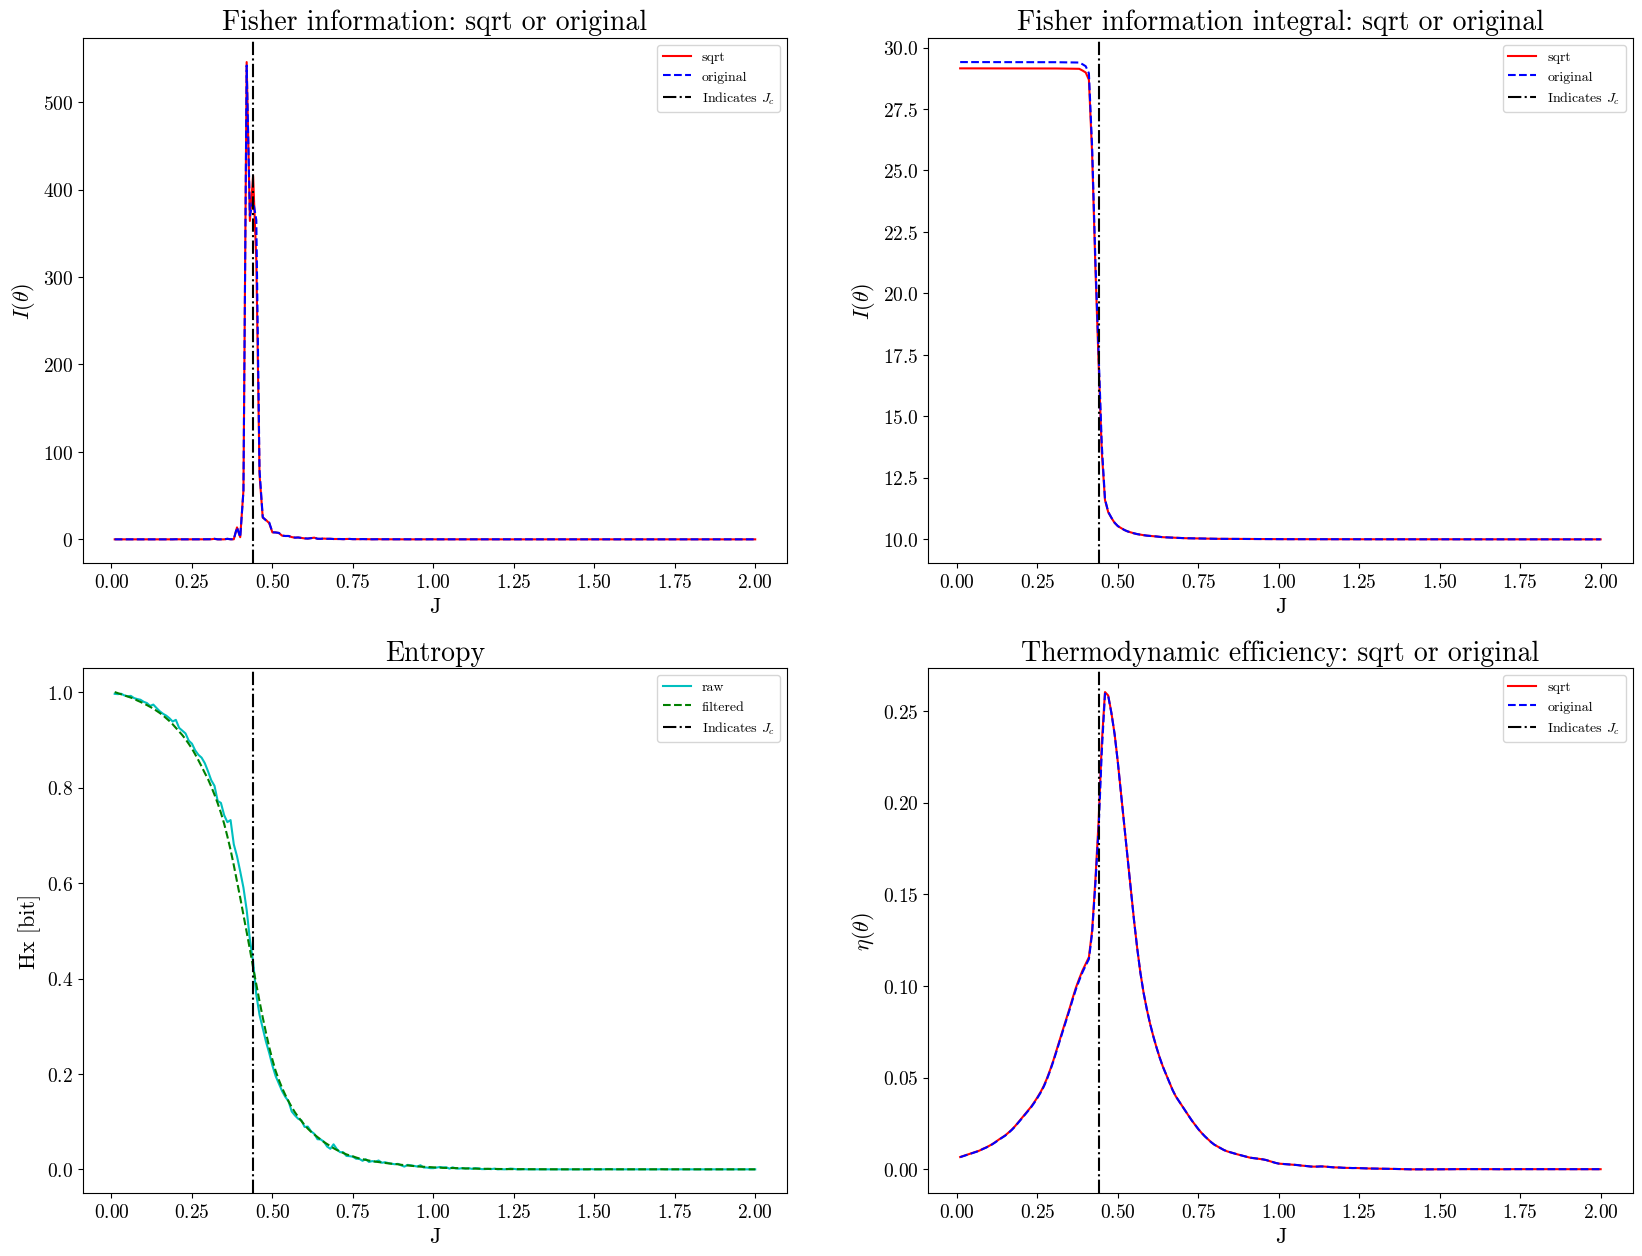

In [29]:
print(f'constant={10} shift integral by 10')
eta_sqrt, eta_orig, hx, numer, fi_sqrt, fi_orig, denom_sqrt, denom_orig = compare_plot_ex3(ave_pdf, ave_entp, get_eta2)

In [ ]:
# interactive plot
# name = 'fisher information'
x = list(ave_entp.keys())
# y1 = list(fi_sqrt.values())
# y2 = list(fi_orig.values())
# y1_label = 'sqrt'
# y2_label = 'orig'

# name = '1/ (fisher integral)'
# y1 = list(1/denom_sqrt)
# y2 = list(1/denom_orig)
# y1_label = 'sqrt'
# y2_label = 'orig'

# name = 'thermodynamic efficiency'
# y1 = list(eta_sqrt.values())
# y2 = list(eta_orig.values())
# y1_label = 'sqrt'
# y2_label = 'orig'

name = 'thermodynamic efficiency constant shift by 10'
y1 = list(eta_sqrt.values())
y2 = list(eta_orig.values())
y1_label = 'sqrt'
y2_label = 'orig'

# name = 'entropy derivative'
# y1 = list(numer)
# y2 = list(numer)
# y1_label = 'entropy derivative'
# y2_label = ''
interactive_plot(name, x[:-20], y1[:-20], y2[:-20], y1_label, y2_label, filename='tmp')

#### 3.7 Try interpolation and integrate to higher $\theta^*$

**Conclusion**:

- Interpolation from fisher_small to fisher_theta_star gives much smoother fisher and fisher integral. Modifications done to get_eta4()
- Summing to a larger value theta* instead of max(fisher.keys()) using the interpolation gives bigger denominator, hence more robust in the division.
- Added parameter to get_eta: theta*, threshold. Should apply this change before testing filters and windowsizes. theta*=10, threshold=5e-2.

In [30]:
%%time

# check fisher around theta*=10
numSims = 10
Js = np.linspace(9.75,10.25,5)
L = 50
time = 1200000 # perform 1.2mil flips
sampleSize = 2000 # take 2k observations to compute average
subsample = 100 # take every 100th sample for subsampling

# values to keep
ave_pdf_star = {}

for j in Js:
    ave_pdf_star[j], _ = run_experiment3(L, time, j, sampleSize, subsample, numSims)

CPU times: user 1min 12s, sys: 480 ms, total: 1min 13s
Wall time: 1min 13s


In [31]:
def get_eta3(configEntropy, fisherInfo, entropyFilt=False, derivativeFilt=False, fisherFilt=False, integralFilt=False, window=14, 
             theta_star=10):
    """
    Compute thermodynamic efficiency. Integrate to theta_star, trapezoidal approx between end of fisherInfo to theta_star.
    
    Parameters:
    configEntropy (dict): A dictionary with parameter and configuration entropy.
    fisherInfo (dict): A dictionary with parameter and Fisher information.
    entropyFilt, derivativeFilt, fisherFilt, integralFilt (bool): switches for filters (Savitzky-Golay filter).
    window (int): window size for the filter.
    
    Returns:
    dict: thermodynamic efficiency eta;
    np.array: configuration entropy values extracted from configEntropy, for checking;
    np.array: numerators for each eta, for checking;
    np.array: fisher information values extracted from fisherInfo, for checking;
    np.array: denominators for each eta, for checking.
    """
    theta = np.array(list(configEntropy.keys()))
    fisher = np.array(list(fisherInfo.values()))
    if theta_star != None and theta_star > theta.max():
        theta = np.append(theta, theta_star)
        fisher = np.append(fisher, 0)
    hx = np.array(list(configEntropy.values()))

    # values to keep
    denominator = {}

    # apply filters: entropy, fisher
    if entropyFilt:
        hx = savgol_filter(hx, window_length=window, polyorder=1)
    if fisherFilt:
        fisher = savgol_filter(fisher[:-1], window_length=window, polyorder=1)
    
    # compute numerator, denominator
    numerator = np.gradient(hx,theta[:len(hx)])
    for i,j in enumerate(theta[:len(hx)]):
        denominator[j] = np.trapz(fisher[i:], theta[i:]) # integrate from theta0 to point to zero-response 10
    denominator = np.array(list(denominator.values()))
    
    # apply filters: derivative, integral
    if derivativeFilt:
        numerator = savgol_filter(numerator, window_length=window, polyorder=1)
    if integralFilt:
        denominator = savgol_filter(denominator, window_length=window, polyorder=1)
    # compute eta
    mask = (abs(denominator) < EPSILON) | (abs(numerator) < EPSILON)
    eta = np.zeros_like(numerator)
    eta[~mask] = -numerator[~mask] / denominator[~mask]
    etaDict = dict(zip(theta, eta))
    return etaDict, hx, numerator, fisher, denominator

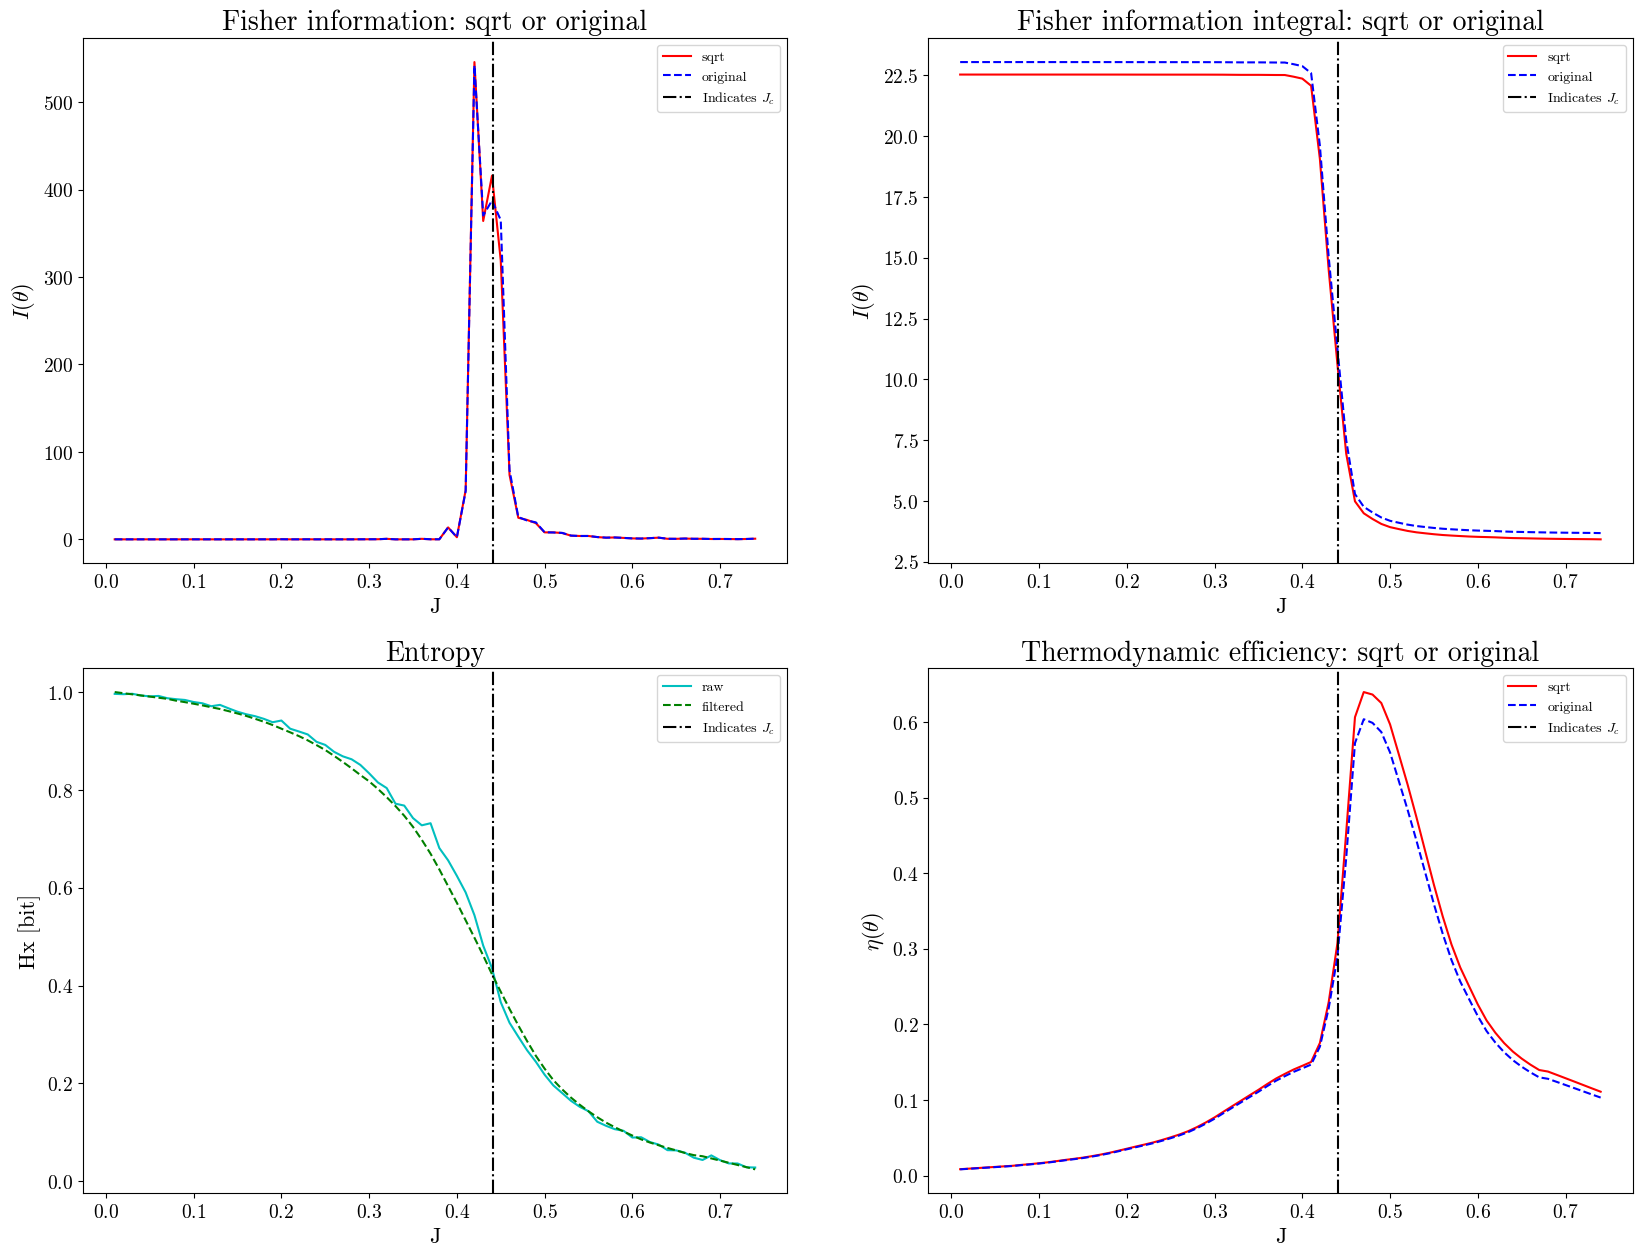

In [32]:
# only plotted to J=0.75, but integrate to J = 10 (linear interpolation)
ave_pdf2 = {k: v for k, v in ave_pdf.items() if k < 0.75}
ave_entp2 = {k: v for k, v in ave_entp.items() if k < 0.75}
eta_sqrt, eta_orig, hx, numer, fi_sqrt, fi_orig, denom_sqrt, denom_orig = compare_plot_ex3(ave_pdf2, ave_entp2, get_eta3)

In [33]:
# padding values of fisher from y_small to 2 using linear interpolation between y_small and 10
# Note: if I pad values using linear interpolation from 0.75 to 10 it will overestimate the integral area by a lot?
x = np.array(list(fisher_sqrt.keys()))
y = np.array(list(fisher_sqrt.values()))

# Identify the last index where y > threshold
threshold = 5e-2
start_index = np.where(y > threshold)[0][-1]

# Define interpolation points
new_x = np.append(x[start_index], 10)
new_y = np.append(y[start_index], 0)

# Create the interpolation function
interp_func = interp1d(new_x, new_y, kind='linear')

# Perform interpolation
x_interp = x[start_index:]
y_interp = interp_func(x_interp)

# pad y for plotting
padding_size = len(y_interp) - len(y[start_index:])
interactive_plot(f'fisher (cutoff-error {threshold})', list(x_interp), list(y_interp), list(y[start_index:]), 'interp', 'original', x2=x[start_index:] ,critical_indicator=False)

In [39]:
# use  the new fisher
new_val = np.append(y[:start_index], y_interp)
fisher_interp = dict(zip(x, new_val))
# interactive_plot('fisher info', list(fisher_interp.keys()), list(fisher_interp.values()), list(fisher_sqrt.values()), 'interp', 'original', critical_indicator=False)

# compute eta
eta_sqrt, hx, numerator, _, fisher_sqrt_intg = get_eta0(ave_entp, fisher_interp, entropyFilt=True, derivativeFilt=True) # new fisher
eta_sqrt1, hx, numerator1, _, fisher_sqrt_intg1 = get_eta4(ave_entp, fisher_interp, entropyFilt=True, derivativeFilt=True, theta_star=10) # new fisher 
eta_sqrt0, hx, numerator0, _, fisher_sqrt_intg0 = get_eta0(ave_entp, fisher_sqrt, entropyFilt=True, derivativeFilt=True) # old fisher

interactive_plot(f'eta (cutoff-error {threshold})', list(eta_sqrt.keys()), list(eta_sqrt.values()), list(eta_sqrt1.values()), 'interp', 'interp and sum to 10', critical_indicator=True)
# interactive_plot(f'fisher integral', list(eta_sqrt.keys()), fisher_sqrt_intg, fisher_sqrt_intg1, 'interp', 'interp and sum to 10', critical_indicator=True)

Comment: using a threshold of 0.5 vs 0.05 effectively shifted the fisher integral up by approx 0.2. This has sufficient effect in making eta more smooth, but even at threshold 0.5 eta still peaks at J ~ 0.51 (right of critical point). As tests shown before we need at least shifting fisher integral by 1 to see actual effect towards critical, and a constant of 10 would make it aligned with criticality. However fisher is very small, to make integral shift up by 10 would probably mean starting at a threshold that is way too large to be justifiable.

In fact, at the heart of this integral problem is the problem of computation resolution. You numerical fisher is not able to detect very small values at J>1, so the integral loses its actual value. Were it analytical fisher, your integral wouldn't be so small.

#### 3.8 Final comparison

In [36]:
# incoporate interpolation and theta* -> final get_eta
def get_eta4(configEntropy, fisherInfo, entropyFilt=False, derivativeFilt=False, fisherFilt=False, integralFilt=False, window=14, 
             theta_star=None, threshold=None):
    """
    Compute thermodynamic efficiency. Interpolate from where fisherInfo < threshold to theta_star.
    
    Parameters:
    configEntropy (dict): A dictionary with parameter and configuration entropy.
    fisherInfo (dict): A dictionary with parameter and Fisher information.
    entropyFilt, derivativeFilt, fisherFilt, integralFilt (bool): switches for filters (Savitzky-Golay filter).
    window (int): window size for the filter.
    
    Returns:
    dict: thermodynamic efficiency eta;
    np.array: configuration entropy values extracted from configEntropy, for checking;
    np.array: numerators for each eta, for checking;
    np.array: fisher information values extracted from fisherInfo, for checking;
    np.array: denominators for each eta, for checking.
    """
    theta = np.array(list(configEntropy.keys()))
    fisher = np.array(list(fisherInfo.values()))
    hx = np.array(list(configEntropy.values()))
    denominator = {} # values to keep

    # Check if sum to theta_star is on:
    if (theta_star != None) and (theta_star > theta.max()):
        theta = np.append(theta, theta_star)
        fisher = np.append(fisher, 0)

        # interpolate between fi_small and fi_thetastar
        if (threshold != None) and (threshold > 0):
            start_index = np.where(fisher > threshold)[0][-1] # find the last index where fisher > threshold
            x = np.append(theta[start_index], theta[-1]) # define starting and end point for interpolation
            y = np.append(fisher[start_index], fisher[-1]) # define starting and end point for interpolation
            interp_func = interp1d(x, y, kind='linear') # Create the interpolation function
            x_interp = theta[start_index:] # Define the range of x values to interpolate over
            y_interp = interp_func(x_interp) # Perform the interpolation
            fisher = np.append(fisher[:start_index], y_interp)

    # apply filters: entropy, fisher
    if entropyFilt:
        hx = savgol_filter(hx, window_length=window, polyorder=1)
    if fisherFilt:
        fisher = savgol_filter(fisher, window_length=window, polyorder=1)
    
    # compute numerator, denominator
    numerator = np.gradient(hx,theta[:len(hx)])
    for i,j in enumerate(theta[:len(hx)]):
        denominator[j] = np.trapz(fisher[i:], theta[i:]) # integrate from theta0 to point to zero-response 10
    denominator = np.array(list(denominator.values()))
    
    # apply filters: derivative, integral
    if derivativeFilt:
        numerator = savgol_filter(numerator, window_length=window, polyorder=1)
    if integralFilt:
        denominator = savgol_filter(denominator, window_length=window, polyorder=1)
    # compute eta
    mask = (abs(denominator) < EPSILON) | (abs(numerator) < EPSILON)
    eta = np.zeros_like(numerator)
    eta[~mask] = -numerator[~mask] / denominator[~mask]
    etaDict = dict(zip(theta, eta))
    return etaDict, hx, numerator, fisher, denominator

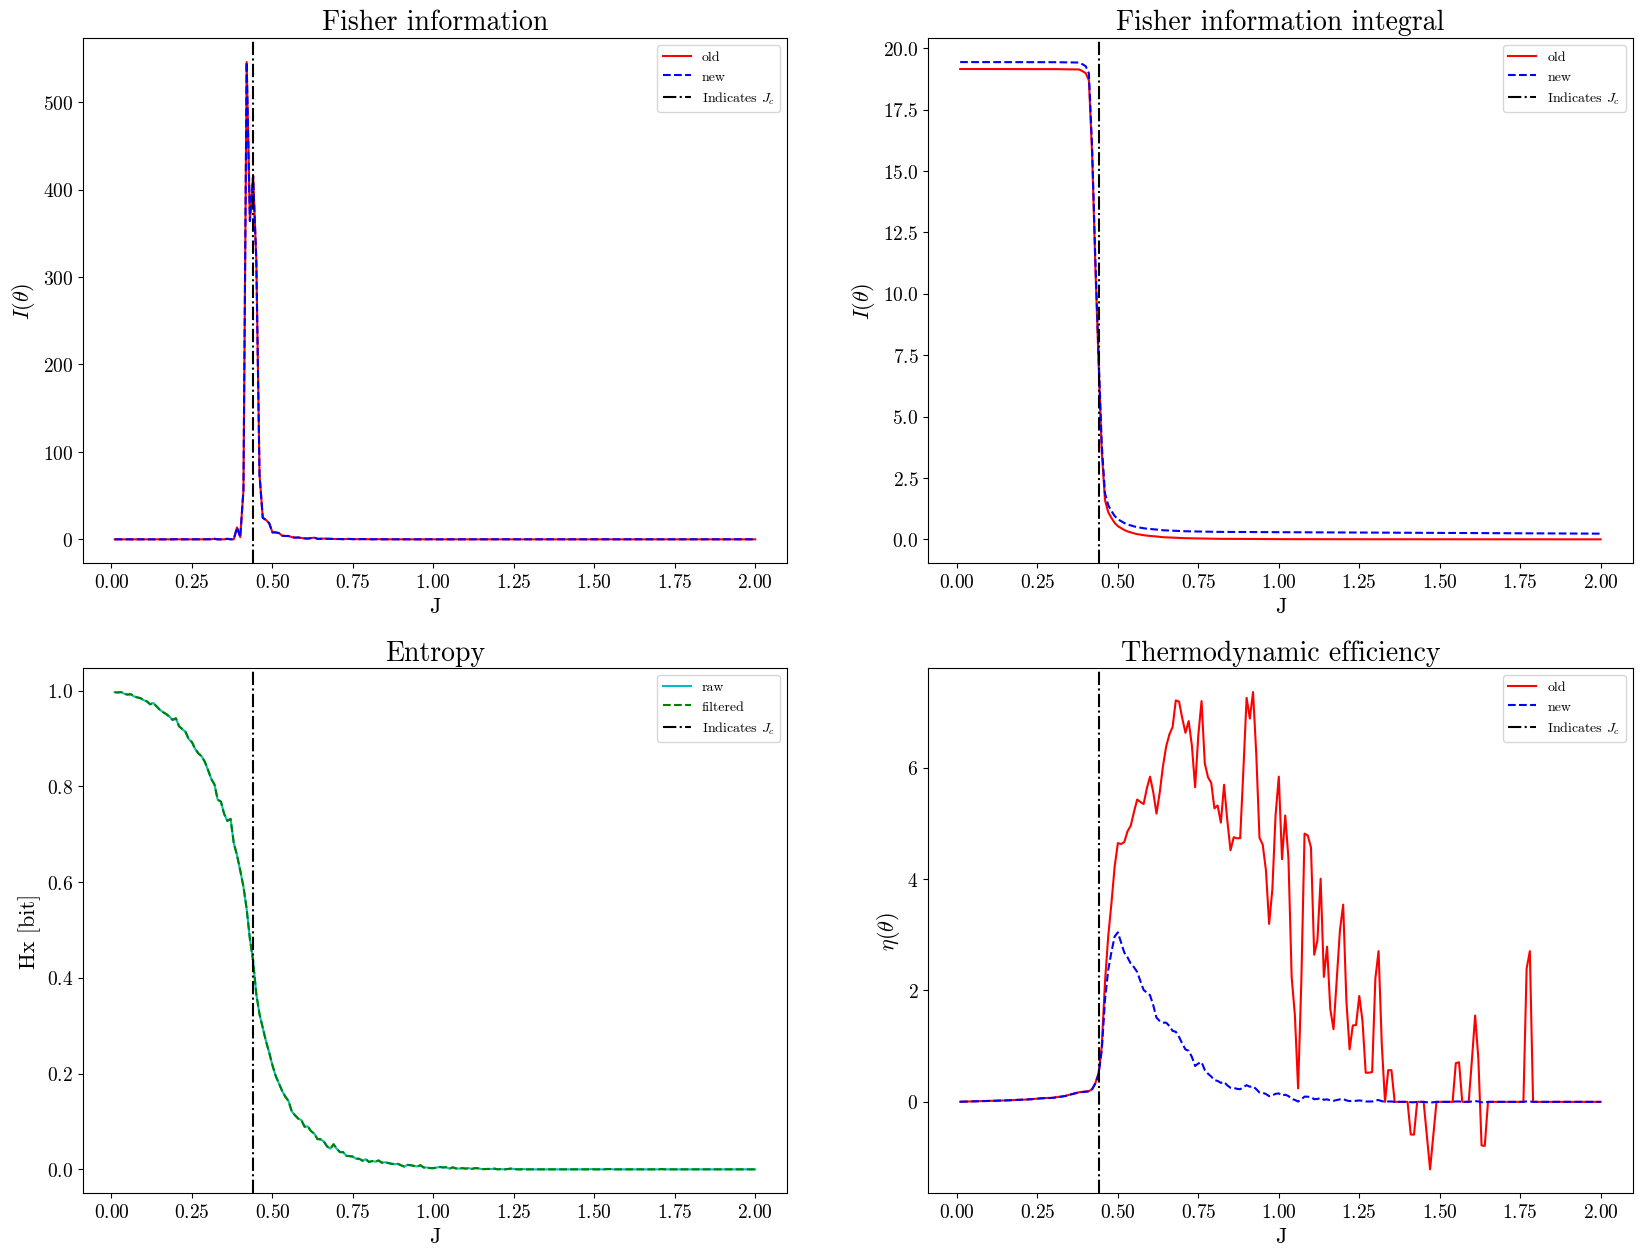

In [44]:
# compare get_eta4 and original get_eta0
# compute fisher and eta
fisher_info = get_fisher(ave_pdf, method='sqrt', mode='discrete')
eta_old, hx, num_old, fi_old, fisher_intg_old = get_eta0(ave_entp, fisher_info, derivativeFilt=True)
eta_new, hx, num_new, fi_new, fisher_intg_new = get_eta4(ave_entp, fisher_info, derivativeFilt=True, theta_star=10, threshold=5e-2)

# compare plots
Js = np.array(list(ave_entp.keys()))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

ax = axes[0][0]
ax.plot(Js, fi_old[:len(hx)], '-', color='r', label='old');
ax.plot(Js, fi_new[:len(hx)], '--', color='b', label='new');
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_xlabel('J')
ax.set_ylabel(r'$I(\theta)$')
ax.set_title('Fisher information');
ax.legend();

ax = axes[0][1]
ax.plot(Js, fisher_intg_old, '-', color='r', label='old');
ax.plot(Js, fisher_intg_new, '--', color='b', label='new');
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_xlabel('J')
ax.set_ylabel(r'$I(\theta)$')
ax.set_title('Fisher information integral');
ax.legend();

ax = axes[1][0]
ax.plot(ave_entp.keys(), ave_entp.values(), '-', color='c', label='raw');
ax.plot(ave_entp.keys(), hx, '--', color='g', label='filtered');
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_xlabel('J')
ax.set_ylabel('Hx [bit]')
ax.set_title('Entropy');
ax.legend();

ax = axes[1][1]
ax.plot(Js, eta_old.values(), '-', color='r', label='old');
ax.plot(Js, eta_new.values(), '--', color='b', label='new');
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_xlabel('J')
ax.set_ylabel(r'$\eta(\theta)$')
ax.set_title('Thermodynamic efficiency');
ax.legend();

In [47]:
# interactive plot
x = list(ave_entp.keys())

# name = 'fisher information'
# y1 = list(fi_old[:len(hx)])
# y2 = list(fi_new[:len(hx)])
# y1_label = 'old'
# y2_label = 'new'

# name = '1/ (fisher integral)'
# y1 = list(1/fisher_intg_old)
# y2 = list(1/fisher_intg_new)
# y1_label = 'old'
# y2_label = 'new'

name = 'fisher integral'
y1 = list(fisher_intg_old)
y2 = list(fisher_intg_new)
y1_label = 'old'
y2_label = 'new'

# name = 'thermodynamic efficiency'
# y1 = list(eta_old.values())
# y2 = list(eta_new.values())
# y1_label = 'old'
# y2_label = 'new'

# name = 'entropy derivative'
# y1 = list(num_old)
# y2 = list(num_new)
# y1_label = 'entropy derivative'
# y2_label = ''
interactive_plot(name, x, y1, y2, y1_label, y2_label, filename='tmp')

### Ex4: Tests on filters
Try turning filters on/off for entropy, entropy derivative, fisher, fisher integral. Compare on smoothness, delay and resulting thermodynamic efficiency.

**Observations**: 

(using original fisher)
- Fig 1: filter on numerator has significant smoothing effect and should not be removed. Filtering on only entropy or only entropy derivative has similar effect. Visible shift in peak.
- Fig 2: filter on denominator magnefies noise in tail and pushes the peak to the right.
- Fig 3: filter on denominator (integral) causes peak to shift to right, and not much smoothing is gain. => remove filter on denominator completely
- Fig 4 $\eta$ is too noisy when remove filter completely. Filter on derivative alone has similar effect to entropy + derivative. Use filter on derivative alone to reduce delay introduced by compounding filters.

(using interpolation for fisher tail)
- Fig 1: filter on numerator has significant smoothing effect and should not be removed. Filtering on only entropy or only entropy derivative has similar effect. No significant shift in peak. => use all filters for numerator.
- Fig 2: filter on denominator no significant impact on tail noise. Visible peak shift to the right. => use no filters for denominator.
- Fig 3: filter on denominator (integral) causes peak to shift to right, and not much smoothing is gain. => remove filter on denominator completely
- Fig 4 $\eta$ is too noisy when remove filter completely. Filter on derivative alone has similar effect to entropy + derivative. Use filter on derivative alone to reduce delay introduced by compounding filters.

**Conclusion**:

use interpolate + integrate to larger theta* + filter eta0100 (only dH/dJ filter on)

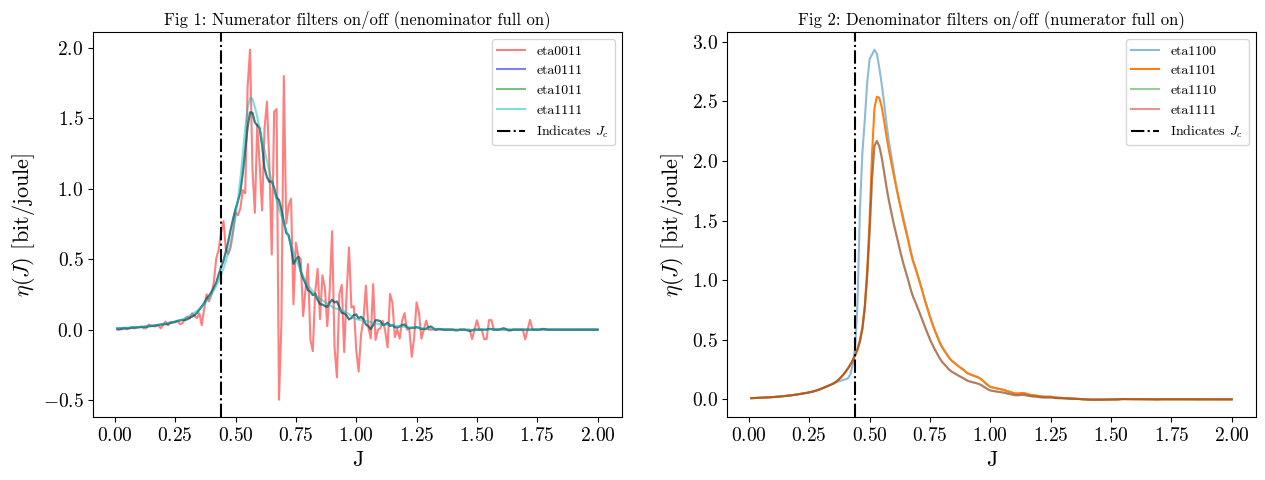

In [48]:
# check filter effect on eta: all combinations, otherwise all on
fisherInfo = get_fisher(ave_pdf, method='sqrt', mode='discrete')
theta_star = 10
threshold = 5e-2
eta0011,h0,n00,f1,d11 = get_eta4(ave_entp, fisherInfo, entropyFilt=False, derivativeFilt=False, fisherFilt=True, integralFilt=True, theta_star=theta_star, threshold=threshold)
eta0111,_,n01,_,_ = get_eta4(ave_entp, fisherInfo, entropyFilt=False, derivativeFilt=True, fisherFilt=True, integralFilt=True, theta_star=theta_star, threshold=threshold)
eta1011,_,n10,_,_ = get_eta4(ave_entp, fisherInfo, entropyFilt=True, derivativeFilt=False, fisherFilt=True, integralFilt=True, theta_star=theta_star, threshold=threshold)
eta1111,_,n11,_,_ = get_eta4(ave_entp, fisherInfo, entropyFilt=True, derivativeFilt=True, fisherFilt=True, integralFilt=True, theta_star=theta_star, threshold=threshold)

eta1100,h1,n11,f0,d00 = get_eta4(ave_entp, fisherInfo, entropyFilt=True, derivativeFilt=True, fisherFilt=False, integralFilt=False, theta_star=theta_star, threshold=threshold)
eta1101,_,_,_,d01 = get_eta4(ave_entp, fisherInfo, entropyFilt=True, derivativeFilt=True, fisherFilt=False, integralFilt=True, theta_star=theta_star, threshold=threshold)
eta1110,_,_,_,d10 = get_eta4(ave_entp, fisherInfo, entropyFilt=True, derivativeFilt=True, fisherFilt=True, integralFilt=False, theta_star=theta_star, threshold=threshold)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(eta0011.keys(), eta0011.values(), 'r', label='eta0011', alpha=0.5) #very noisy: numerator filter should not be removed
ax.plot(eta0111.keys(), eta0111.values(), 'b', label='eta0111', alpha=0.5) #similar to 1011
ax.plot(eta1011.keys(), eta1011.values(), 'g', label='eta1011', alpha=0.5) #similar to 0111
ax.plot(eta1111.keys(), eta1111.values(), 'c', label='eta1111', alpha=0.5) #most smooth, no visible shift in peak
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');

ax.set_title('Fig 1: Numerator filters on/off (nenominator full on)', fontsize=12);
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');
ax.legend();

ax = axes[1]
ax.plot(eta1100.keys(), eta1100.values(), label='eta1100', alpha=0.5)
ax.plot(eta1101.keys(), eta1101.values(), label='eta1101') #same as 1111 in smooth and peak
ax.plot(eta1110.keys(), eta1110.values(), label='eta1110', alpha=0.5) #same as 1111 in smooth and peak
ax.plot(eta1111.keys(), eta1110.values(), label='eta1111', alpha=0.5) #most smooth, but visible shift in peak
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_title('Fig 2: Denominator filters on/off (numerator full on)', fontsize=12);
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');
ax.legend();

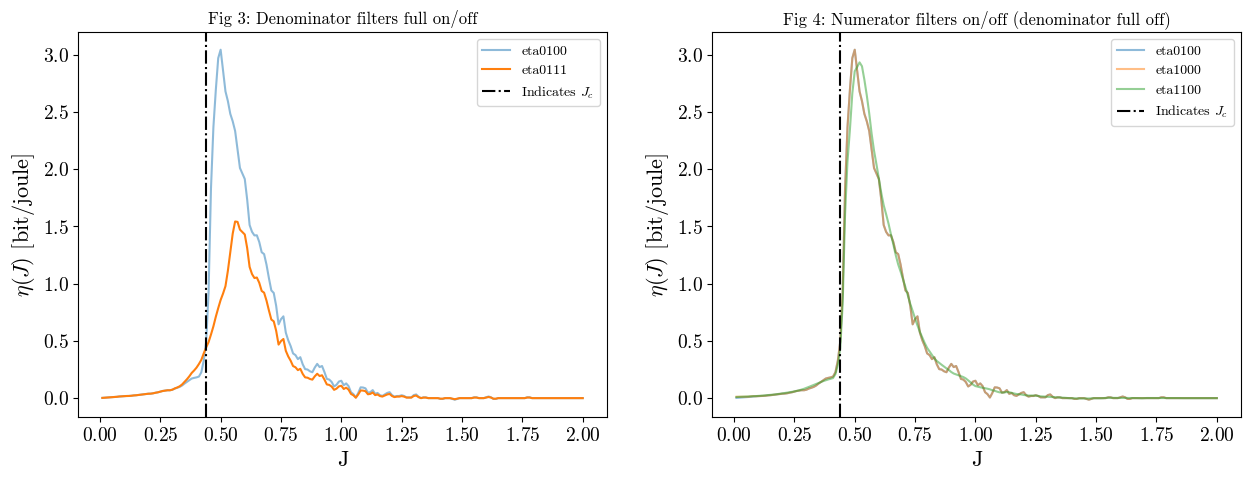

In [49]:
# Check filter effect on eta: all combinations, otherwise all off
eta0100,_,_,_,_ = get_eta4(ave_entp, fisherInfo, entropyFilt=False, derivativeFilt=True, fisherFilt=False, integralFilt=False, theta_star=theta_star, threshold=threshold)
eta1000,_,_,_,_ = get_eta4(ave_entp, fisherInfo, entropyFilt=True, derivativeFilt=False, fisherFilt=False, integralFilt=False, theta_star=theta_star, threshold=threshold)
eta0000,_,_,_,_ = get_eta4(ave_entp, fisherInfo, entropyFilt=False, derivativeFilt=False, fisherFilt=False, integralFilt=False, theta_star=theta_star, threshold=threshold)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(eta0100.keys(), eta0100.values(), label='eta0100', alpha=0.5)
ax.plot(eta0111.keys(), eta0111.values(), label='eta0111')
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_title('Fig 3: Denominator filters full on/off', fontsize=12);
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');
ax.legend();

ax = axes[1]
# ax.plot(eta0000.keys(), eta0000.values(), label='eta0000', alpha=0.5)
ax.plot(eta0100.keys(), eta0100.values(), label='eta0100', alpha=0.5)
ax.plot(eta1000.keys(), eta1000.values(), label='eta1000', alpha=0.5)
ax.plot(eta1100.keys(), eta1100.values(), label='eta1100', alpha=0.5)
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_title('Fig 4: Numerator filters on/off (denominator full off)', fontsize=12);
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');
ax.legend();

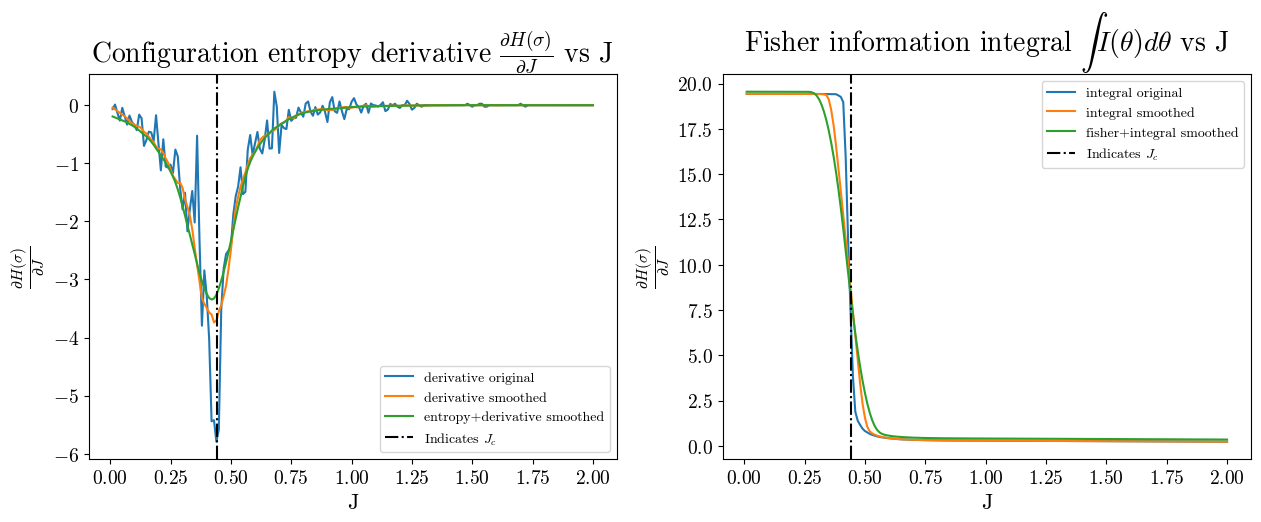

In [50]:
# check filter delay effect for numerator and denominator
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(eta0100.keys(), n00, label='derivative original')
ax.plot(eta0100.keys(), n01, label='derivative smoothed')
ax.plot(eta0100.keys(), n11, label='entropy+derivative smoothed')
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_title(r'Configuration entropy derivative $\frac{\partial H(\sigma)}{\partial J}$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H(\sigma)}{\partial J}$');
ax.legend();

ax = axes[1]
ax.plot(eta0100.keys(), d00, label='integral original')
ax.plot(eta0100.keys(), d01, label='integral smoothed')
ax.plot(eta0100.keys(), d11, label='fisher+integral smoothed')
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_title(r'Fisher information integral $\int I(\theta)d\theta$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H(\sigma)}{\partial J}$');
ax.legend();

### Ex5: Tests on window size
Try different window sizes. Compare on smoothness, delay and resulting thermodynamic efficiency.

Note: the 'scipy.signal.savgol_filter' functionthe window is symmetric around the point being filtered. https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

**Conclusion**:

- window size = 15 is suitable for both smoothness and minimal impact on delay

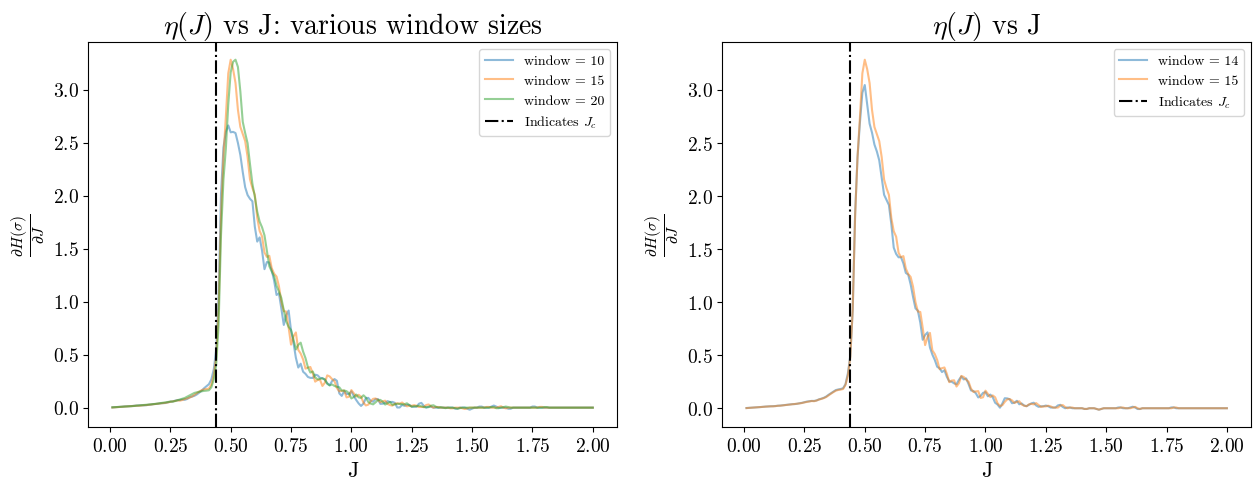

In [51]:
# try different window sizes, eta0100
# eta8,_,_,_,_ = get_eta4(ave_entp, fisherInfo, derivativeFilt=True, window=8, theta_star=theta_star, threshold=threshold)
eta10,_,_,_,_ = get_eta4(ave_entp, fisherInfo, derivativeFilt=True, window=10, theta_star=theta_star, threshold=threshold)
# eta12,_,_,_,_ = get_eta4(ave_entp, fisherInfo, derivativeFilt=True, window=12, theta_star=theta_star, threshold=threshold)
eta14,_,_,_,_ = get_eta4(ave_entp, fisherInfo, derivativeFilt=True, window=14, theta_star=theta_star, threshold=threshold)
eta15,_,_,_,_ = get_eta4(ave_entp, fisherInfo, derivativeFilt=True, window=15, theta_star=theta_star, threshold=threshold)
eta20,_,_,_,_ = get_eta4(ave_entp, fisherInfo, derivativeFilt=True, window=20, theta_star=theta_star, threshold=threshold)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
# ax.plot(eta8.keys(), eta8.values(), label='window = 8',alpha=0.5)
ax.plot(eta10.keys(), eta10.values(), label='window = 10',alpha=0.5)
ax.plot(eta15.keys(), eta15.values(), label='window = 15',alpha=0.5)
ax.plot(eta20.keys(), eta20.values(), label='window = 20',alpha=0.5)
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_title(r'$\eta(J)$ vs J: various window sizes');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H(\sigma)}{\partial J}$');
ax.legend();

ax = axes[1]
ax.plot(eta14.keys(), eta14.values(), label='window = 14',alpha=0.5)
ax.plot(eta15.keys(), eta15.values(), label='window = 15',alpha=0.5)
ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
ax.set_title(r'$\eta(J)$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H(\sigma)}{\partial J}$');
ax.legend();

### Ex6: Tests on numSim and dJ
Try different (numSim, dJ) combinations, untill average $\eta$ computed in different sets of simulation different by no more than EPSILON.

**Conclusion**:


In [52]:
# retrieve Mbar and average entropy
def run_experiment6(L, time, j, sampleSize, subsample, numSims):
    M_total = 0
    entp_total = 0
    
    for _ in range(numSims):
        lattice = initialise(L, bias=0.75)  # initialize lattice
        _, _, _, mags, _ = metropolis(lattice, time, j, get_mu(lattice))  # run one simulation
        subsamples = mags[-sampleSize*subsample:][::subsample]  # subsampling to 1/10
        M_total += subsamples.sum()
        entp_total += get_entropy_kikuchi(lattice)

    return M_total / (numSims * sampleSize), entp_total / numSims

def compare_plot_ex6(result_sets, name, numSim, dJ):
    print(f'numSim={numSims}, dJ={dJ:.4f}')
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    ax = axes[0]
    for i in range(numSets):
        ax.plot(Js, result_sets[i], label=f'set {i}')
    ax.axvline(x=np.log(1+2**0.5)/2, color='k', linestyle='-.', label='Indicates $J_c$');
    ax.set_xlabel('J');
    ax.set_ylabel(name);
    ax.set_title(f'{name} across different sets');
    ax.legend();
    
    ax = axes[1]
    results_mean, std_dev = quantify_variations(result_sets)
    ax.plot(Js, results_mean, label='Mean Curve', color='blue');
    ax.fill_between(Js, results_mean - std_dev, results_mean + std_dev, color='blue', alpha=0.2, label='1 Std Dev');
    ax.set_title('Mean and std_dev across sets');
    ax.set_xlabel('J');
    ax.set_ylabel(name); 

#### 6.1 Run experiments

In [ ]:
%%time
# Run different sets of simulations using the same (numSim, dJ) configuration parameters
numSims = 20
Js = np.linspace(0.01,2,200)
L = 50
time = 1200000 # perform 1.2mil flips
sampleSize = 2000 # take 2k observations to compute average
subsample = 100 # take every 100th sample for subsampling
numSets = 5

# values to keep
result_sets_mbar = np.zeros((numSets, len(Js)))
result_sets_aveEntp = np.zeros((numSets, len(Js)))

# Use Parallel processing
for i in range(numSets):
    results = Parallel(n_jobs=-1)(delayed(run_experiment6)(L, time, j, sampleSize, subsample, numSims) for j in Js)
    result_sets_mbar[i, :] = [res[0] for res in results]
    result_sets_aveEntp[i, :] = [res[1] for res in results]

# Compute eta for each set, compare variation between sets
theta_star = 10
threshold = 5e-2
result_sets_eta =  np.zeros((numSets, len(Js)))
result_sets_etrp = np.zeros((numSets, len(Js)))
result_sets_num = np.zeros((numSets, len(Js)))
result_sets_fi  = np.zeros((numSets, len(Js)))
result_sets_den = np.zeros((numSets, len(Js)))

for i in range(numSets):
    # retrieve average entropy and average pdf for each J
    ave_entp = dict(zip(Js, result_sets_aveEntp[i, :]))
    ave_pdf = {}
    for j_idx, j_val in enumerate(Js):
        Mbar = result_sets_mbar[i,j_idx]
        ave_pdf[j_val] = {1:(1 + Mbar) / 2, -1:(1 - Mbar) / 2}
    
    # compute fisher info and eta for set i
    fisherInfo = get_fisher(ave_pdf, method='sqrt', mode='discrete')
    eta,hx,num,fi,den = get_eta4(ave_entp, fisherInfo, derivativeFilt=True, window=15, theta_star=theta_star, threshold=threshold)
    result_sets_eta[i, :] = list(eta.values())
    result_sets_etrp[i, :] = hx
    result_sets_num[i, :] = num
    result_sets_fi[i, :]  = fi[:len(Js)]
    result_sets_den[i, :] = den

print(f'L={L}, numSim={numSims}, dJ={Js[1]-Js[0]:.4f}, time={time}, sampleSize={sampleSize}, subsample={subsample}')

In [ ]:
# Export data
combined_data = {
    'numSims'            : numSims,
    'Js'                 : Js.tolist(),
    'L'                  : L,
    'time'               : time,
    'sampleSize'         : sampleSize,
    'subsample'          : subsample,
    'numSets'            : numSets,
    'result_sets_mbar'   : result_sets_mbar.tolist(),
    'result_sets_aveEntp': result_sets_aveEntp.tolist(),
    'result_sets_eta'    : result_sets_eta.tolist(),
    'result_sets_etrp'   : result_sets_etrp.tolist(),
    'result_sets_num'    : result_sets_num.tolist(),
    'result_sets_fi'     : result_sets_fi.tolist(),
    'result_sets_den'    : result_sets_den.tolist()
}

# Save combined data to a JSON file
with open('data_ex6_20240811_numSim20_J200.json', 'w') as json_file:
    json.dump(combined_data, json_file)

#### 6.2 visualisation

In [55]:
# Reload data
with open('data_ex6_20240811_numSim5_J100.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Access individual dictionaries
numSims = loaded_data['numSims']   
Js                  = np.array(loaded_data['Js'])     
L                   = loaded_data['L']         
time                = loaded_data['time']      
sampleSize          = loaded_data['sampleSize']
subsample           = loaded_data['subsample'] 
numSets             = loaded_data['numSets']   
result_sets_mbar    = np.array(loaded_data['result_sets_mbar']   ).reshape((numSets,len(Js)))
result_sets_aveEntp = np.array(loaded_data['result_sets_aveEntp']).reshape((numSets,len(Js)))
result_sets_eta     = np.array(loaded_data['result_sets_eta']    ).reshape((numSets,len(Js)))
result_sets_etr     = np.array(loaded_data['result_sets_etrp']   ).reshape((numSets,len(Js)))
result_sets_num     = np.array(loaded_data['result_sets_num']    ).reshape((numSets,len(Js)))
result_sets_fi      = np.array(loaded_data['result_sets_fi']     ).reshape((numSets,len(Js)))
result_sets_den     = np.array(loaded_data['result_sets_den']    ).reshape((numSets,len(Js)))

numSim=5, dJ=0.0201
nmse = 7.47
mae = 7.7558


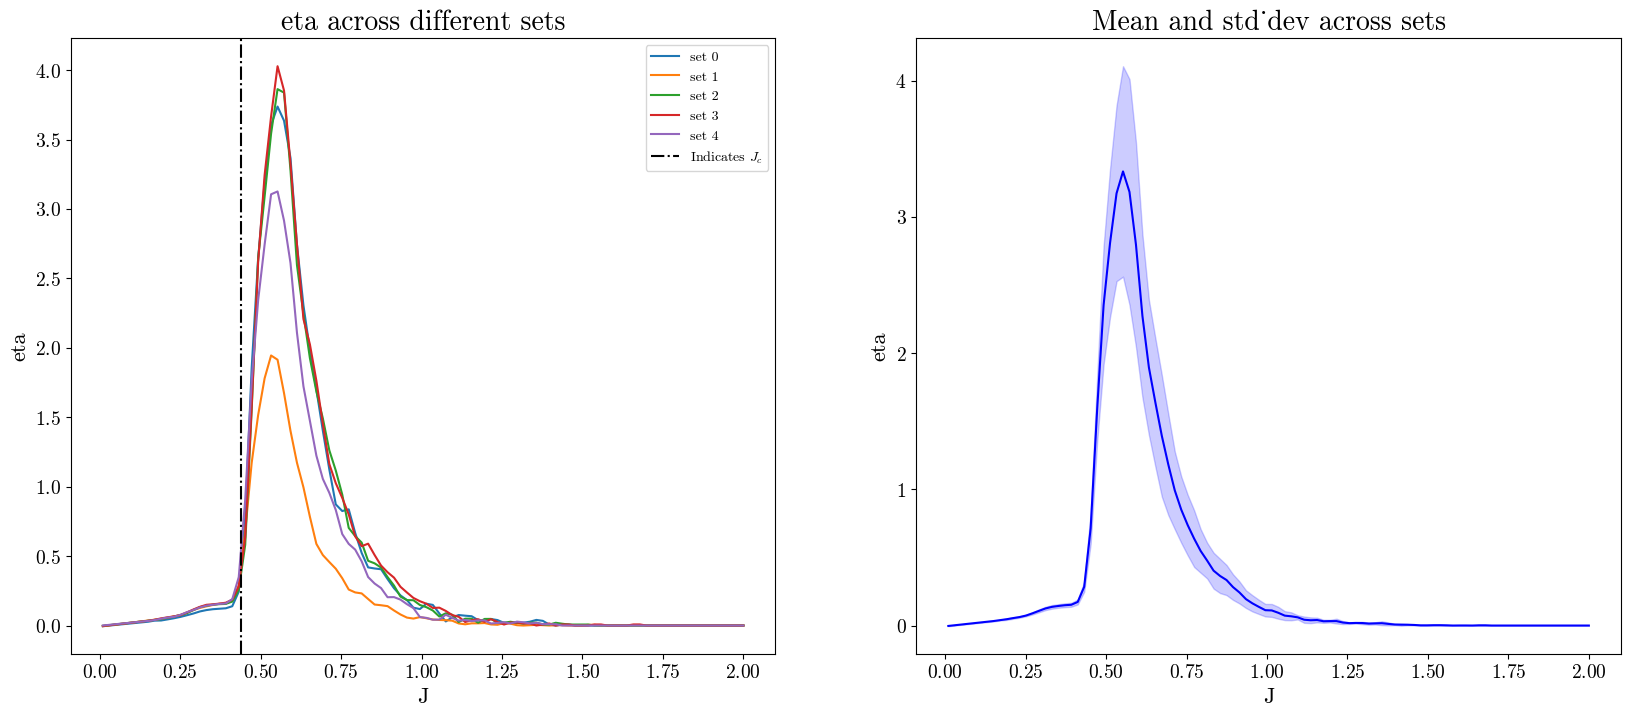

In [56]:
# visualise results
compare_plot_ex6(result_sets_eta, 'eta', numSims, Js[1]-Js[0])